This is a Kaggle [data set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). You are given a large set of features for a set of house sold over a period of 5 years and asked to predict the Sale price on a test set. 
I dig into the data, comparing the train and test distribution across different features. With such a large number of features it is not difficult  to get a good prediction - but I try to see how much I can improve the prediction by combining several independent predictors.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import kurtosis
from scipy.stats import skew
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

from xgboost import XGBRegressor 
!pip install catboost
import catboost

import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from matplotlib.ticker import StrMethodFormatter



     |████████████████████████████████| 66.1MB 53kB/s 


# EDA

First I do a quick dive into the data.

In [ ]:
train_df = pd.read_csv('/content/data/train.csv')
test_df = pd.read_csv('/content/data/test.csv')
submission_df = pd.read_csv('/content/data/sample_submission.csv')


In [ ]:
#missing features
train_df[train_df.columns[np.where(np.sum(train_df.isnull())>0)[0]]].isnull().sum()
train_df.loc[train_df.LotFrontage.isnull(),'LotFrontage']  = 0;train_df.loc[train_df.Fence.isnull(),'Fence']  = 'NF'
train_df.loc[train_df.Alley.isnull(),'Alley']  = 'NA';train_df.loc[train_df.GarageType.isnull(),'GarageType']  = 'NG'
train_df.loc[train_df.GarageFinish.isnull(),'GarageFinish']  = 'NG';train_df.loc[train_df.GarageCond.isnull(),'GarageCond']  = 'NG'
train_df.loc[train_df.GarageQual.isnull(),'GarageQual']  = 'NG';train_df.loc[train_df.GarageType.isnull(),'GarageType']  = 'NG'
train_df.loc[train_df.GarageYrBlt.isnull(),'GarageYrBlt']  = 0;train_df.loc[train_df.BsmtFinType1.isnull(),'BsmtFinType1']  = 'NB'
train_df.loc[train_df.BsmtQual.isnull(),'BsmtQual']  = 'NB';train_df.loc[train_df.BsmtCond.isnull(),'BsmtCond']  = 'NB'
train_df.loc[train_df.BsmtExposure.isnull(),'BsmtExposure']  = 'NB';train_df.loc[train_df.BsmtFinType2.isnull(),'BsmtFinType2']  = 'NB'
train_df.loc[train_df.MasVnrType.isnull(),'MasVnrType']  = 'none';train_df.loc[train_df.MasVnrArea.isnull(),'MasVnrArea']  = 0
train_df.loc[train_df.PoolQC.isnull(),'PoolQC']  = 'NP';train_df.loc[train_df.FireplaceQu.isnull(),'FireplaceQu']  = 'NF'
train_df.loc[train_df.MiscFeature.isnull(),'MiscFeature']  = 'none';train_df.loc[train_df.Electrical.isnull(),'Electrical']  = 'Mix'

test_df[test_df.columns[np.where(np.sum(test_df.isnull())>0)[0]]].isnull().sum()
test_df.loc[test_df.LotFrontage.isnull(),'LotFrontage']  = 0;test_df.loc[test_df.Fence.isnull(),'Fence']  = 'NF'
test_df.loc[test_df.Alley.isnull(),'Alley']  = 'NA';test_df.loc[test_df.GarageType.isnull(),'GarageType']  = 'NG'
test_df.loc[test_df.GarageFinish.isnull(),'GarageFinish']  = 'NG';test_df.loc[test_df.GarageCond.isnull(),'GarageCond']  = 'NG'
test_df.loc[test_df.GarageQual.isnull(),'GarageQual']  = 'NG';test_df.loc[test_df.GarageType.isnull(),'GarageType']  = 'NG'
test_df.loc[test_df.GarageYrBlt.isnull(),'GarageYrBlt']  = 0;test_df.loc[test_df.BsmtFinType1.isnull(),'BsmtFinType1']  = 'NB'
test_df.loc[test_df.BsmtQual.isnull(),'BsmtQual']  = 'NB';test_df.loc[test_df.BsmtCond.isnull(),'BsmtCond']  = 'NB'
test_df.loc[test_df.BsmtExposure.isnull(),'BsmtExposure']  = 'NB';test_df.loc[test_df.BsmtFinType2.isnull(),'BsmtFinType2']  = 'NB'
test_df.loc[test_df.MasVnrType.isnull(),'MasVnrType']  = 'none';test_df.loc[test_df.MasVnrArea.isnull(),'MasVnrArea']  = 0
test_df.loc[test_df.PoolQC.isnull(),'PoolQC']  = 'NP';test_df.loc[test_df.FireplaceQu.isnull(),'FireplaceQu']  = 'NF'
test_df.loc[test_df.MiscFeature.isnull(),'MiscFeature']  = 'none';test_df.loc[test_df.Electrical.isnull(),'Electrical']  = 'Mix'


# for any still missing features use the mode of the feature on test
for c in test_df.columns[np.where(np.sum(test_df.isnull())>0)[0]]:
  test_df.loc[test_df[c].isnull(),c] = test_df[c].mode().values[0]


I introduce a few new features here - it seeems to make sense to for example to combine features like YearBuilt and YrSold to calculat the age of the property when sold. Also I want to look at price per square foot to see if I can find any patterns.

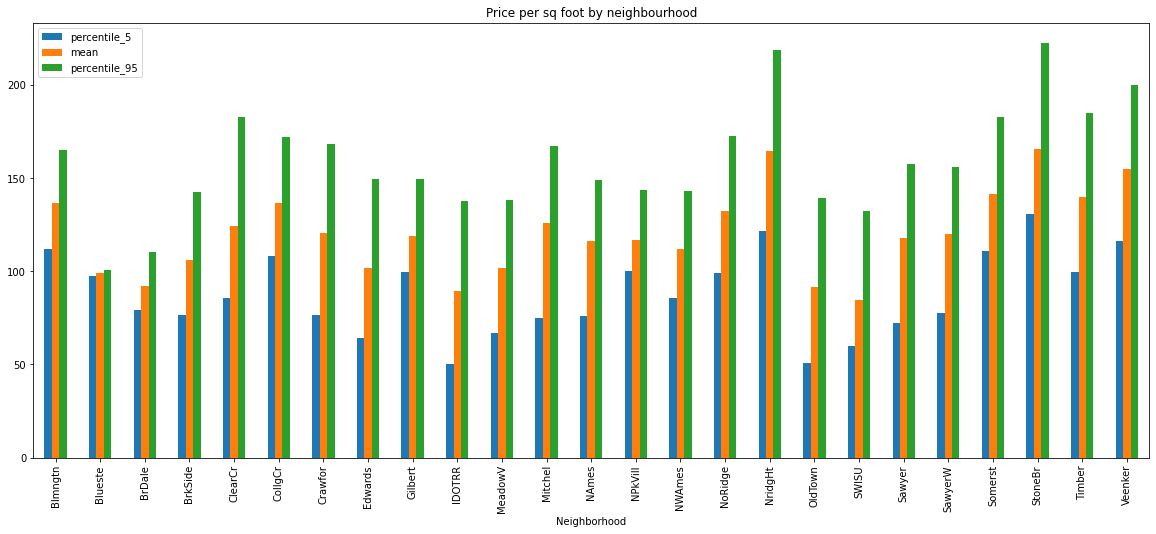

In [ ]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

train_df['Age'] = train_df['YrSold'] - train_df['YearBuilt']
train_df['RemodAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
train_df['DateSold'] = [dt(r[1].YrSold,r[1].MoSold,1) for r in train_df.iterrows()]
train_df['GarageAge'] = train_df['YrSold'] - train_df['GarageYrBlt']

test_df['Age'] = test_df['YrSold'] - test_df['YearBuilt']
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']
test_df['GarageAge'] = test_df['YrSold'] - test_df['GarageYrBlt']
test_df['DateSold'] = [dt(r[1].YrSold,r[1].MoSold,1) for r in test_df.iterrows()]


train_df['PricePerSqFoot'] = train_df['SalePrice']/train_df['GrLivArea']

train_df.groupby('Neighborhood').PricePerSqFoot.agg([percentile(5),'mean',percentile(95)]).plot(kind='bar')
fig = plt.gca()
fig.set_title('Price per sq foot by neighbourhood')
fig.figure.set_size_inches(20,8)

Clearly neighbourhood is a key feature, as price per square foot by neighbourhood shows. But why do prices vary even within neighbourhoods?

In [ ]:
neigh_ppqft = train_df.groupby(['Neighborhood']).PricePerSqFoot.mean().to_frame()
neigh_ppqft.rename(columns={'PricePerSqFoot':'NeighAvgPPSF'},inplace=True)
train_df = pd.merge(train_df,neigh_ppqft,on='Neighborhood',how='left')
train_df['DeltaPPSF'] = train_df.PricePerSqFoot - train_df.NeighAvgPPSF

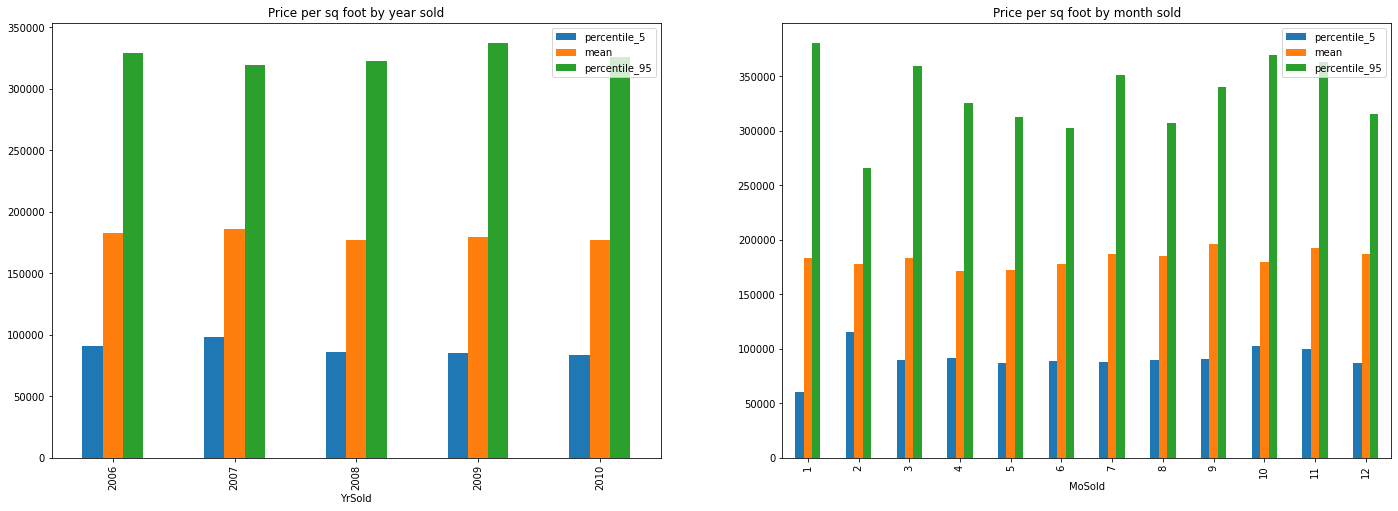

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(24,8))
train_df.groupby('YrSold').SalePrice.agg([percentile(5),'mean',percentile(95)]).plot(kind='bar',ax=axs[0],title='Price per sq foot by year sold');
train_df.groupby('MoSold').SalePrice.agg([percentile(5),'mean',percentile(95)]).plot(kind='bar',ax=axs[1],title='Price per sq foot by month sold');

Surprisingly, year of sale doesn't appear to impact the price very much. There ia some seasonality evident with prices generally depressed in summer months. Do either of the quality features explain the diversity of price per square foot within neighbourhoods?

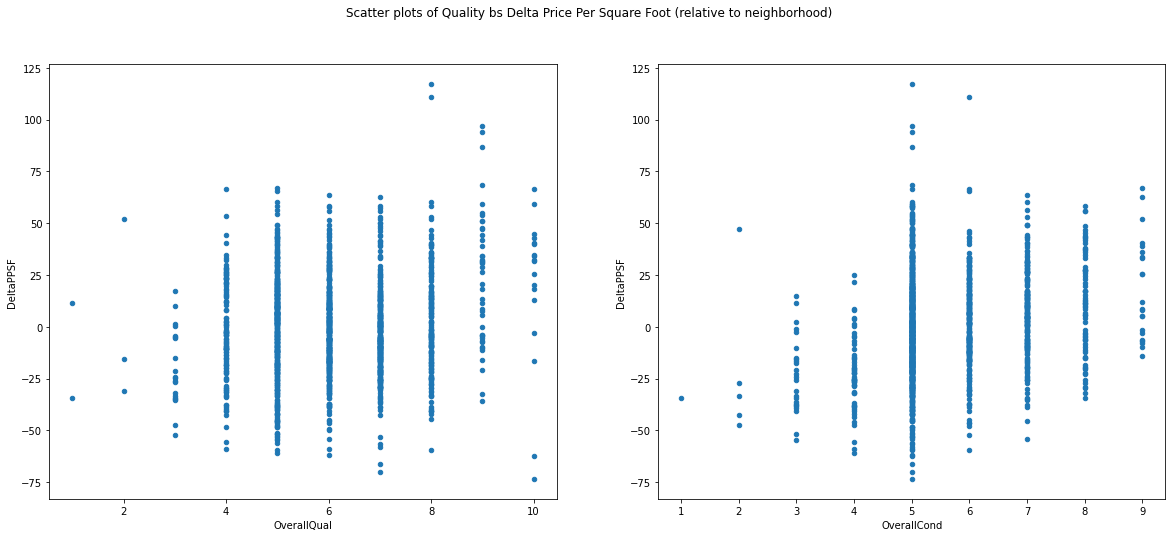

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(20,8));
fig.suptitle('Scatter plots of Quality bs Delta Price Per Square Foot (relative to neighborhood)')
train_df.plot.scatter(x='OverallQual',y='DeltaPPSF',ax=axs[0]);
train_df.plot.scatter(x='OverallCond',y='DeltaPPSF',ax=axs[1]);

Next I look at the features in aggregate. There are both numerical features (eg GrLivArea which is above Ground Living Area) and categorical features (like Neighbourhood). For numerical features I calculate the correlaton to target below.

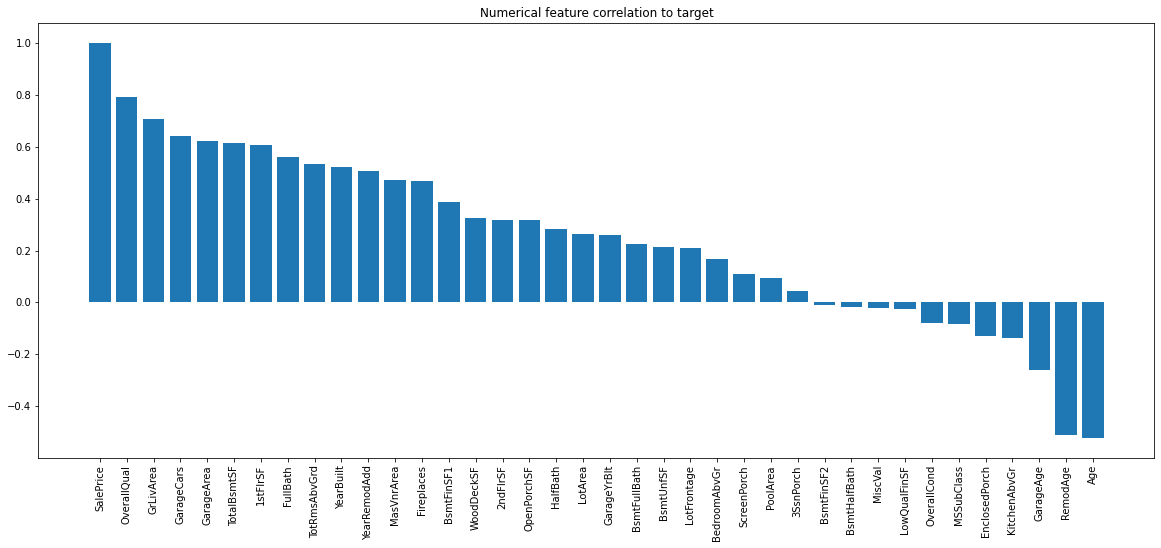

In [ ]:
#Identify the datatype of variables

categorical_features = train_df.columns[np.where((train_df.dtypes == np.object))[0]].values
categorical_features = np.concatenate((categorical_features,np.array(['MoSold','YrSold'])))
cat_boost_categorical_features = categorical_features
cat_boost_categorical_features = np.concatenate((cat_boost_categorical_features,np.array(['OverallCond','OverallQual','MSSubClass','BsmtFullBath','BsmtHalfBath'])))
cat_boost_categorical_features = np.concatenate((cat_boost_categorical_features,np.array(['FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','GarageCars','Fireplaces'])))
numerical_features = train_df.columns[~train_df.columns.isin(categorical_features)]
numerical_features = numerical_features[~np.isin(numerical_features,['Id','PricePerSqFoot','NeighAvgPPSF','DeltaPPSF','DateSold'])]
num_feat_corrs = np.array([np.corrcoef(train_df.SalePrice,train_df[f])[0,1] for f in numerical_features])
idx = np.argsort(num_feat_corrs)[::-1]
fig,axs = plt.subplots(1,1,figsize=(20,8))
plt.bar(numerical_features[idx],num_feat_corrs[idx])
plt.xticks(rotation=90);
plt.title('Numerical feature correlation to target');

As might be expected Condition (which is ordinal and can be treated as numerical) and area are the most important while the various age features have large negative correlations. To view the categorical features I will look at [violin plots](https://seaborn.pydata.org/generated/seaborn.violinplot.html). For example look a YrSold.


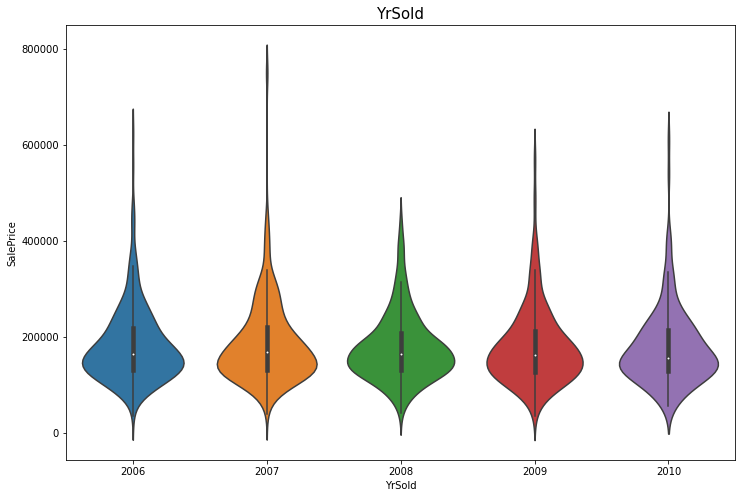

In [ ]:
  fig,ax = plt.subplots(1,1,figsize=(12,8))
  sns.violinplot(x='YrSold',y='SalePrice',data=train_df,ax=ax)
  ax.set_title('YrSold',Fontsize=15)
  plt.show()

The different values produce very similar plots, indicating that this feature value doesn't give us much information. Contrast this with ExterQual (the quality of the material on the exterior) which takes the following values
*  Ex	Excellent
*  Gd	Good
*  TA	Average/Typical
*  Fa	Fair
*  Po	Poor

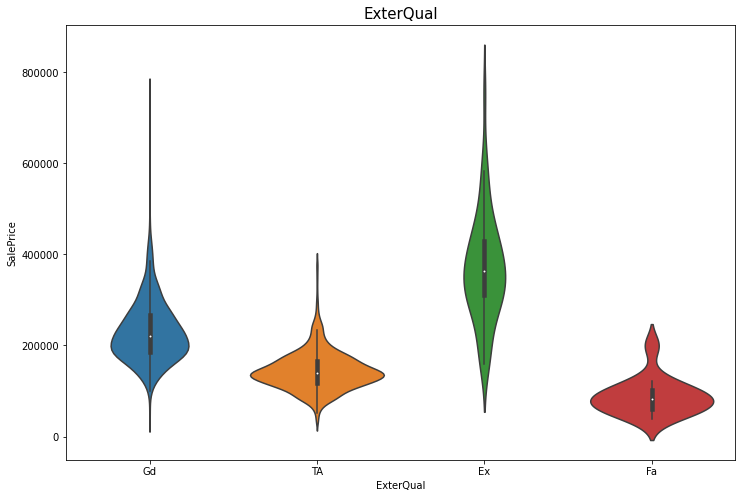

In [ ]:
  fig,ax = plt.subplots(1,1,figsize=(12,8))
  sns.violinplot(x='ExterQual',y='SalePrice',data=train_df,ax=ax)
  ax.set_title('ExterQual',Fontsize=15)
  plt.show()


Here is the equivalent chart for neighborhood.

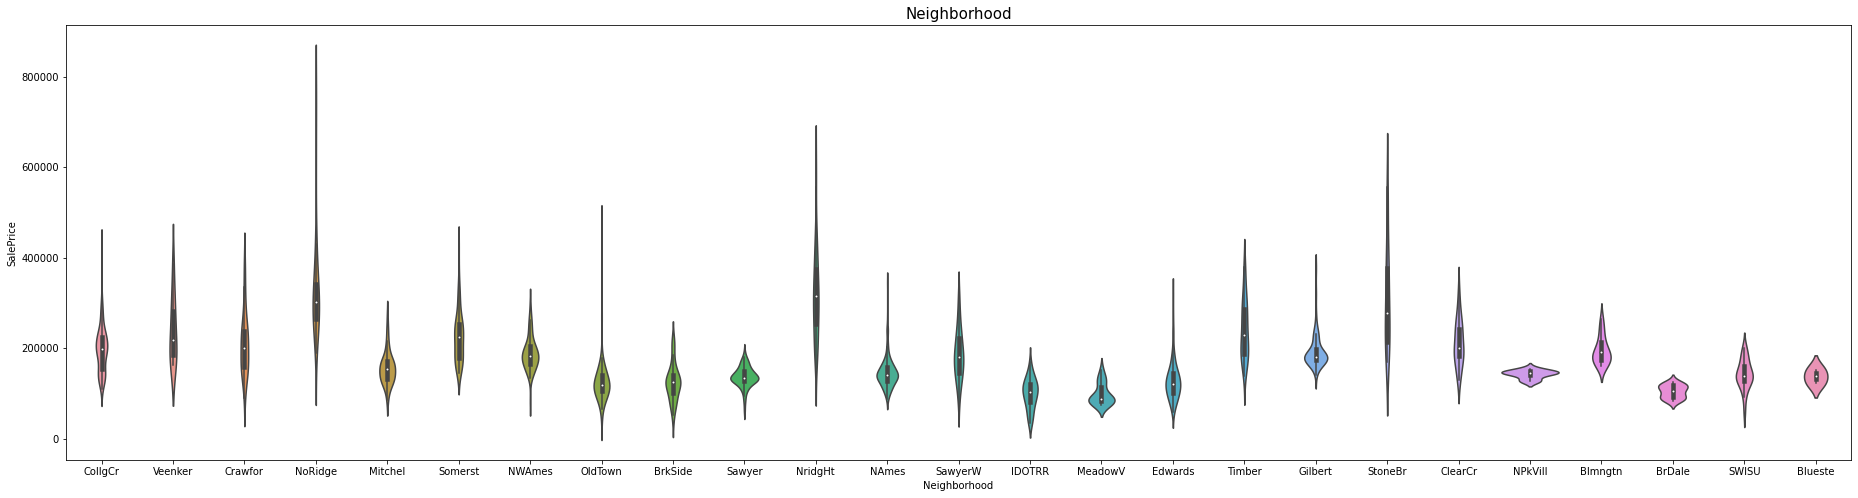

In [ ]:
  fig,ax = plt.subplots(1,1,figsize=(32,8))
  sns.violinplot(x='Neighborhood',y='SalePrice',data=train_df,ax=ax)
  ax.set_title('Neighborhood',Fontsize=15)
  plt.show()


Finally I show  this plot for all categorical features with no more than 5 categories. Generally features concerned with quality seem to contain the most information.

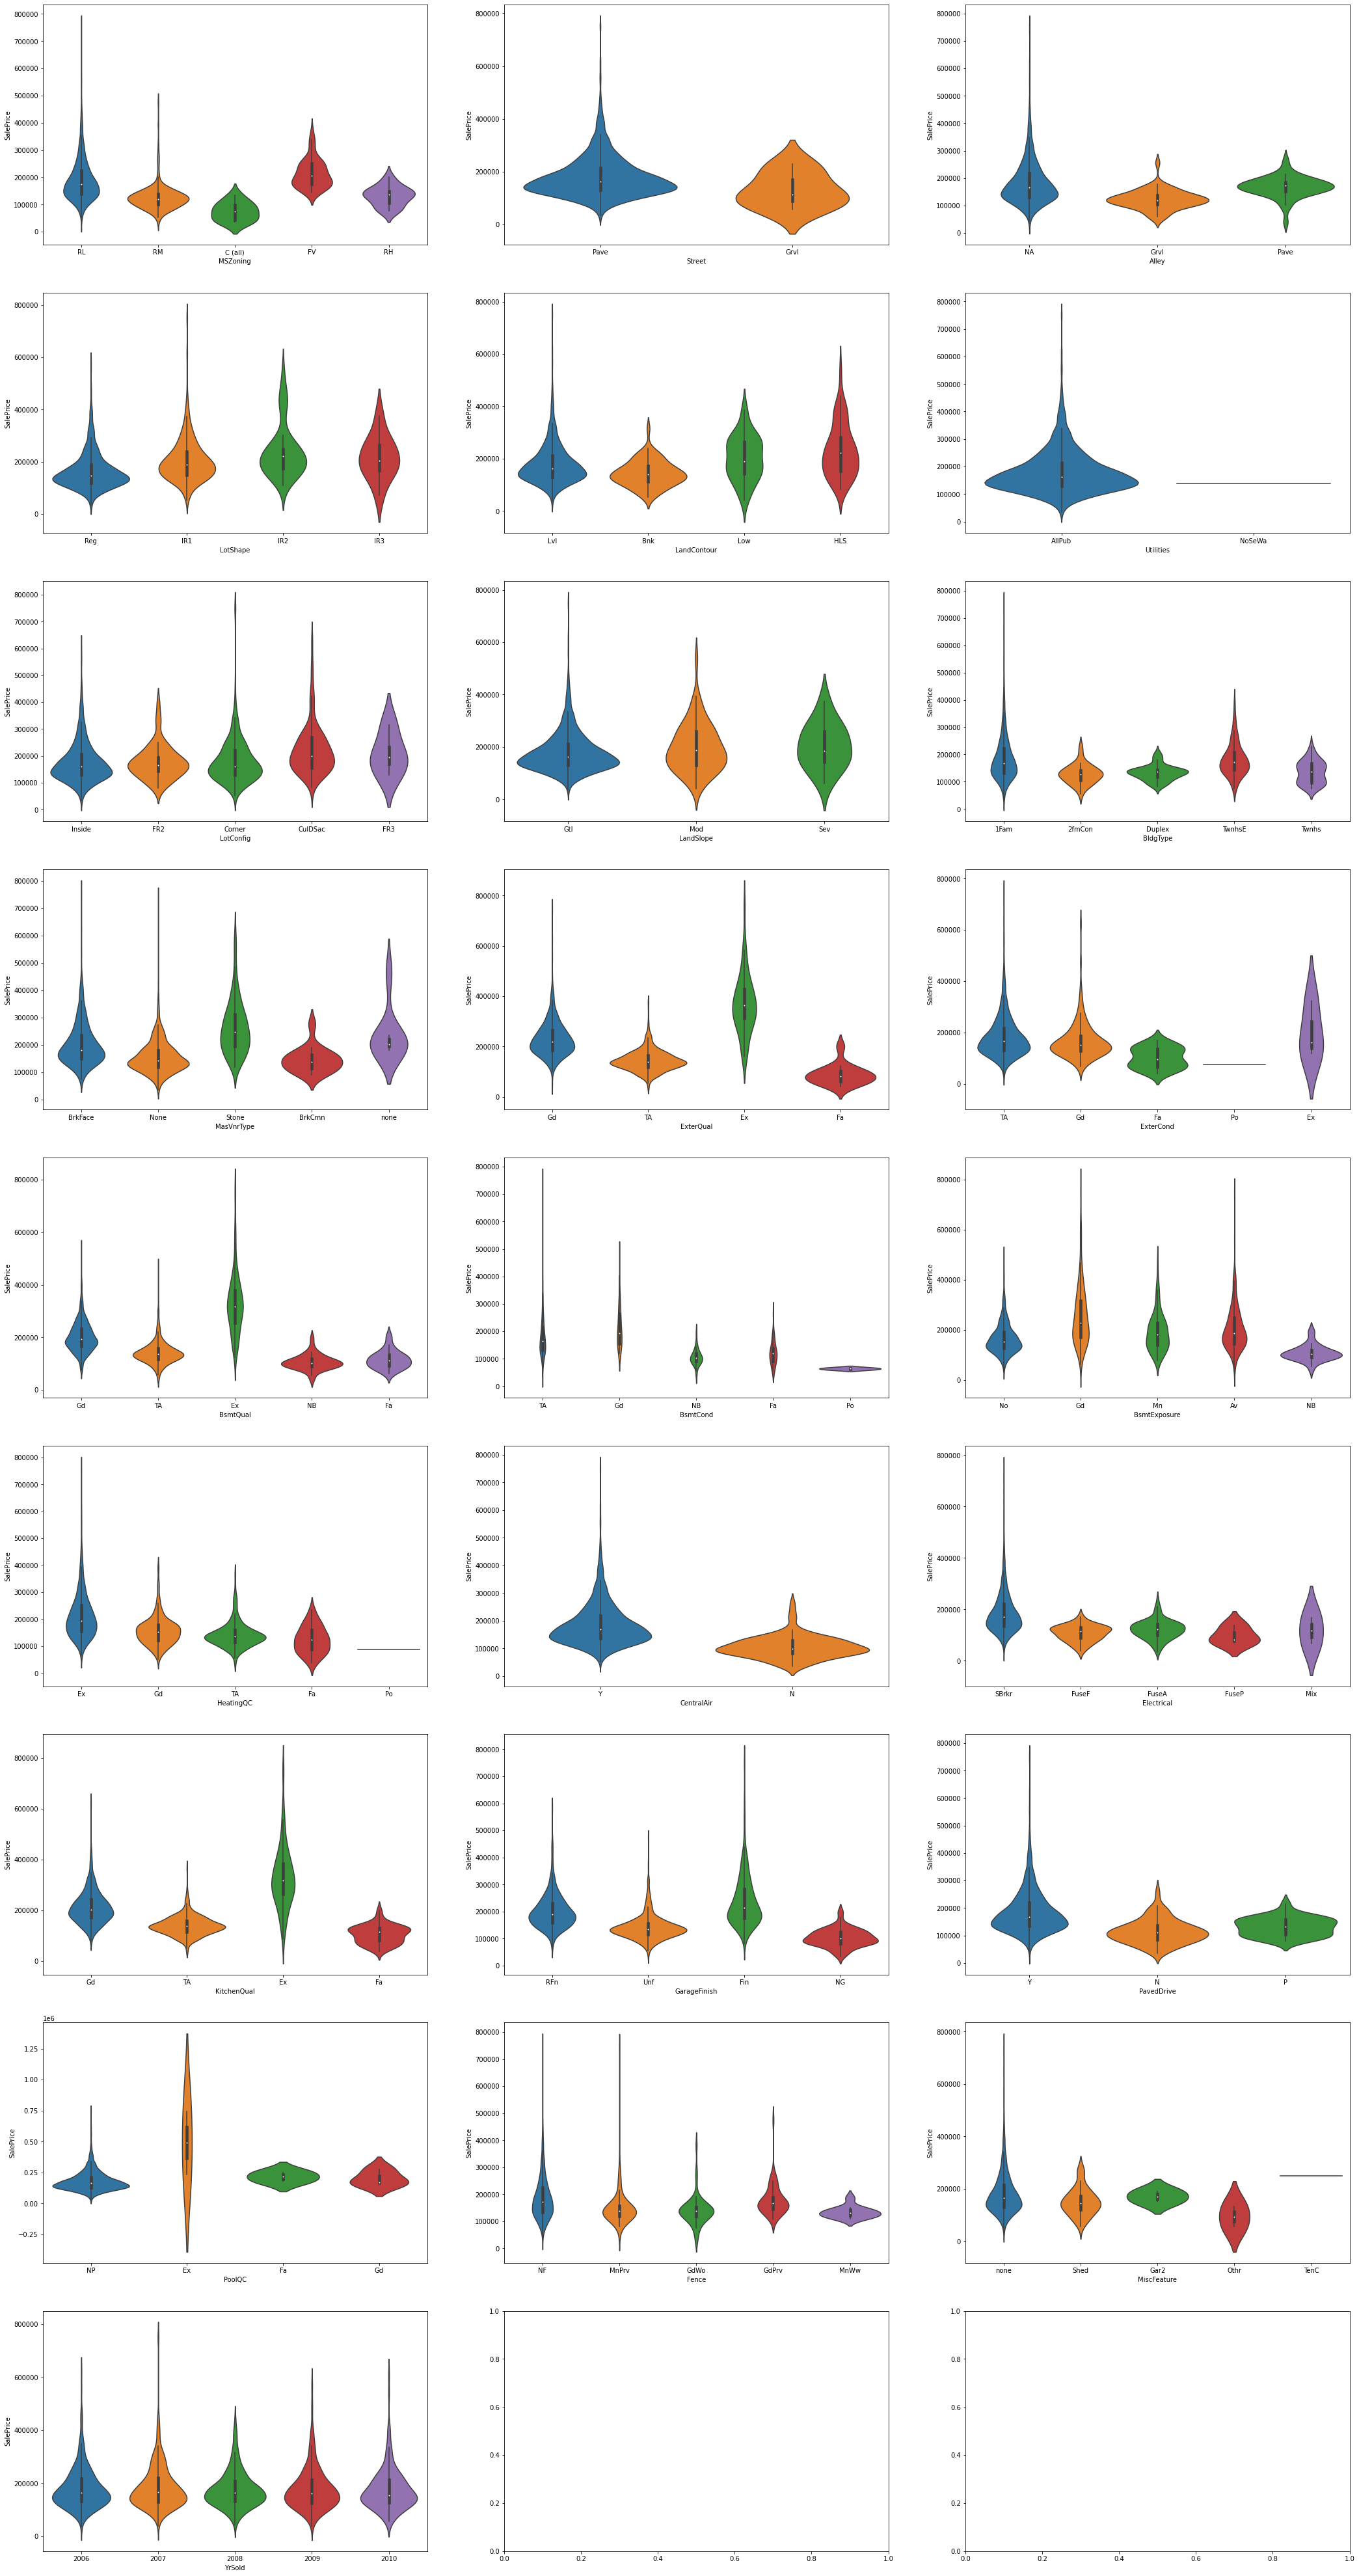

In [ ]:
n_plots = categorical_features[np.array([train_df[f].nunique() for f in categorical_features])<6].shape[0]
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))
fig,axs = plt.subplots(n_rows,n_cols,figsize=(n_cols*12,n_rows*8))
for i,f in enumerate(categorical_features[np.array([train_df[f].nunique() for f in categorical_features])<6]):
  sns.violinplot(x=f,y='SalePrice',data=train_df,ax=axs[int(np.floor(i/n_cols))][np.mod(i,n_cols)])
  ax.set_title(f,Fontsize=50)
plt.show()


# Comparing test and training data

Now I compare the test set to the training set to see if I can detect any biases in either set.

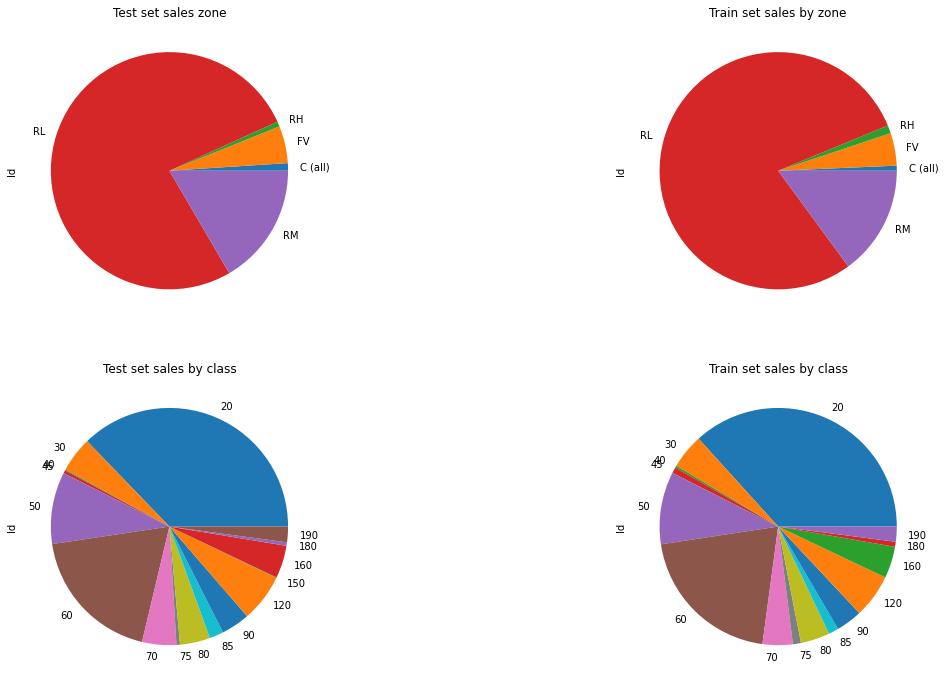

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,12));
test_df.groupby(['MSZoning']).Id.count().plot.pie(ax=axs[0][0],title='Test set sales zone');
train_df.groupby(['MSZoning']).Id.count().plot.pie(ax=axs[0][1],title='Train set sales by zone');

test_df.groupby(['MSSubClass']).Id.count().plot.pie(ax = axs[1][0],title='Test set sales by class');
train_df.groupby(['MSSubClass']).Id.count().plot.pie(ax = axs[1][1],title='Train set sales by class');


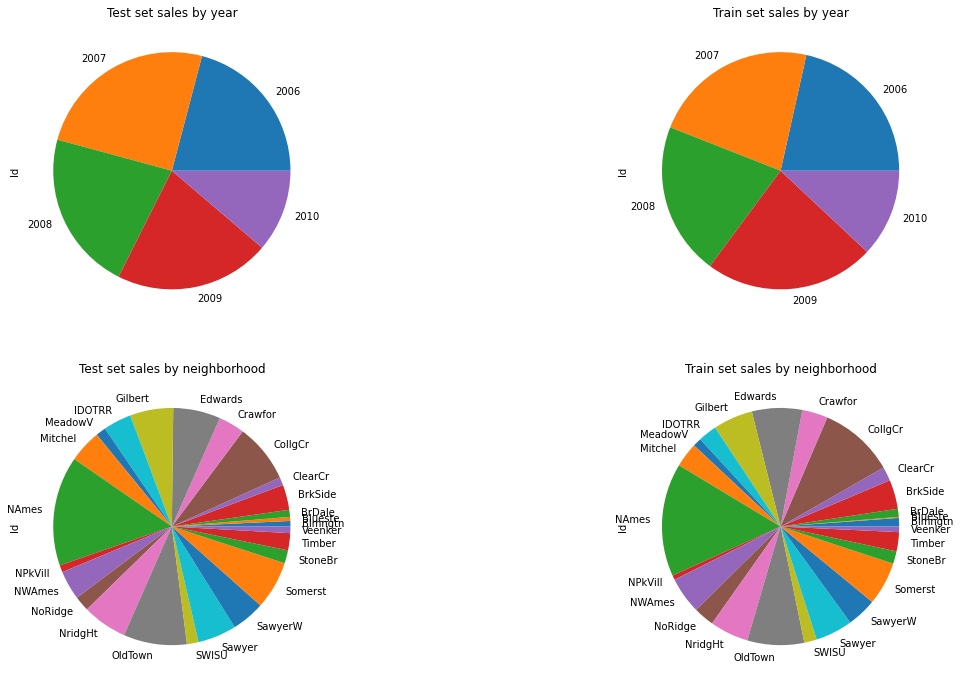

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,12));
test_df.groupby(['YrSold']).Id.count().plot.pie(ax=axs[0][0],title='Test set sales by year');
train_df.groupby(['YrSold']).Id.count().plot.pie(ax=axs[0][1],title='Train set sales by year');

test_df.groupby(['Neighborhood']).Id.count().plot.pie(ax = axs[1][0],title='Test set sales by neighborhood');
train_df.groupby(['Neighborhood']).Id.count().plot.pie(ax = axs[1][1],title='Train set sales by neighborhood');

The zone, class, year of sale and neighbourhood are consistently distributed across test and train. I look at all the features together - first the categorical ones - (below the blue histogram represents train and the orange one is test).

In [ ]:
n_plots = cat_boost_categorical_features.shape[0]
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))
fig,axs = plt.subplots(n_rows,n_cols,figsize=(n_cols*36,n_rows*16))
for i,feat in enumerate(cat_boost_categorical_features):
  ax = axs[int(np.floor(i/n_cols))][np.mod(i,n_cols)]
  counts = pd.concat([train_df[feat].value_counts(),test_df[feat].value_counts()],join='outer',axis=1)
  ax.bar(np.arange(counts.shape[0])-0.5,counts.iloc[:,0],width=.4)
  ax.bar(np.arange(counts.shape[0]),counts.iloc[:,1],width=.4)
  #ax.xticks(np.arange(counts.shape[0]),rotation=90,labels=counts.index)
  #ax.title(feat)
  ax.xaxis.set_ticks(np.arange(counts.shape[0]))
  ax.xaxis.set_ticklabels(counts.index,rotation=90,Fontsize=40)
  ax.set_title(feat,Fontsize=40)
plt.tight_layout()
plt.show()


#feat = categorical_features[4]


Now for numerical features.

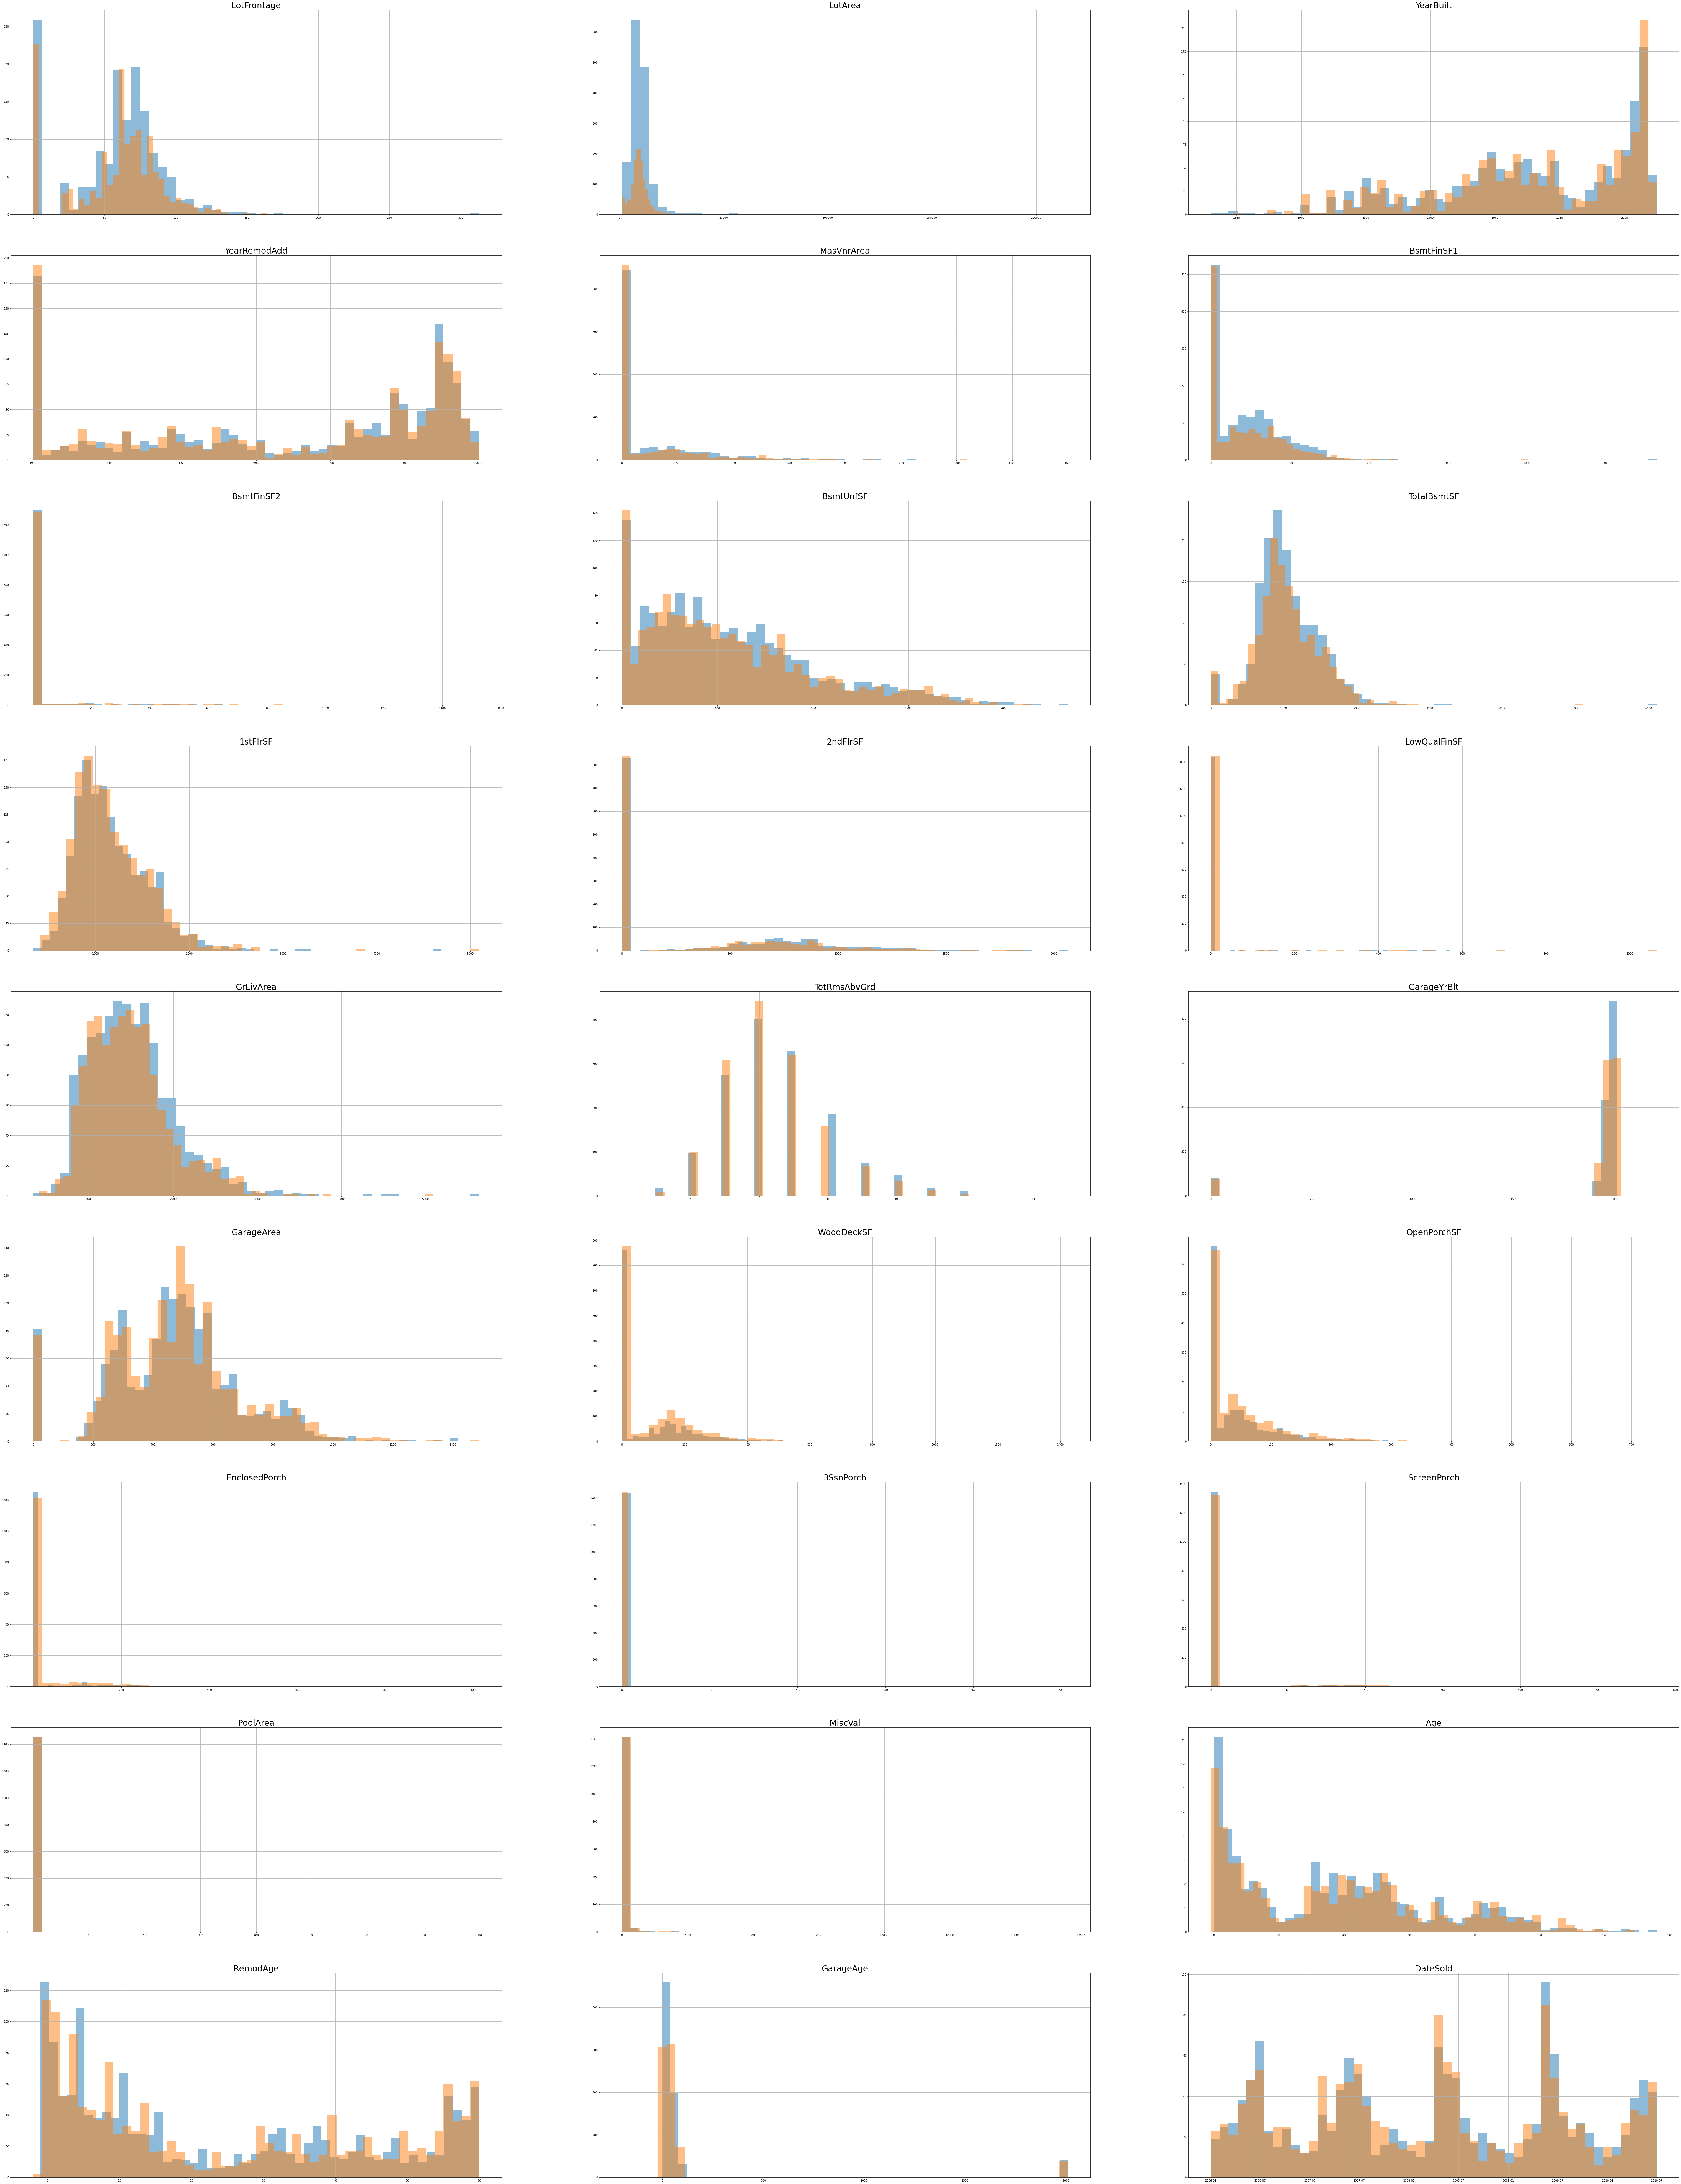

In [ ]:
cat_boost_numerical_features = test_df.columns[~test_df.columns.isin(cat_boost_categorical_features)]
cat_boost_numerical_features = cat_boost_numerical_features[1:]
n_plots = cat_boost_numerical_features.shape[0]
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))
fig,axs = plt.subplots(n_rows,n_cols,figsize=(n_cols*36,n_rows*16))
for i,feat in enumerate(cat_boost_numerical_features):
  ax = axs[int(np.floor(i/n_cols))][np.mod(i,n_cols)]
  train_df[feat].hist(bins=50, ax=ax,alpha=.5)
  test_df[feat].hist(bins=50, ax=ax,alpha=.5)
  ax.set_title(feat,Fontsize=30)
plt.show()

All of the histograms are remarkably consistent and the test and train data has been properly split, so there is no concern that models fitted on training data should not generalise well to test.

# Data Preparation  

Now I prepare the set I will use for training and validation and convert categorical variables to one-hot vectors where necessary. The cat boost algorithm takes care of converting categorical variables so I keep to copies of train / validation / test sets - one with categorical variables and one with one-hot variables.

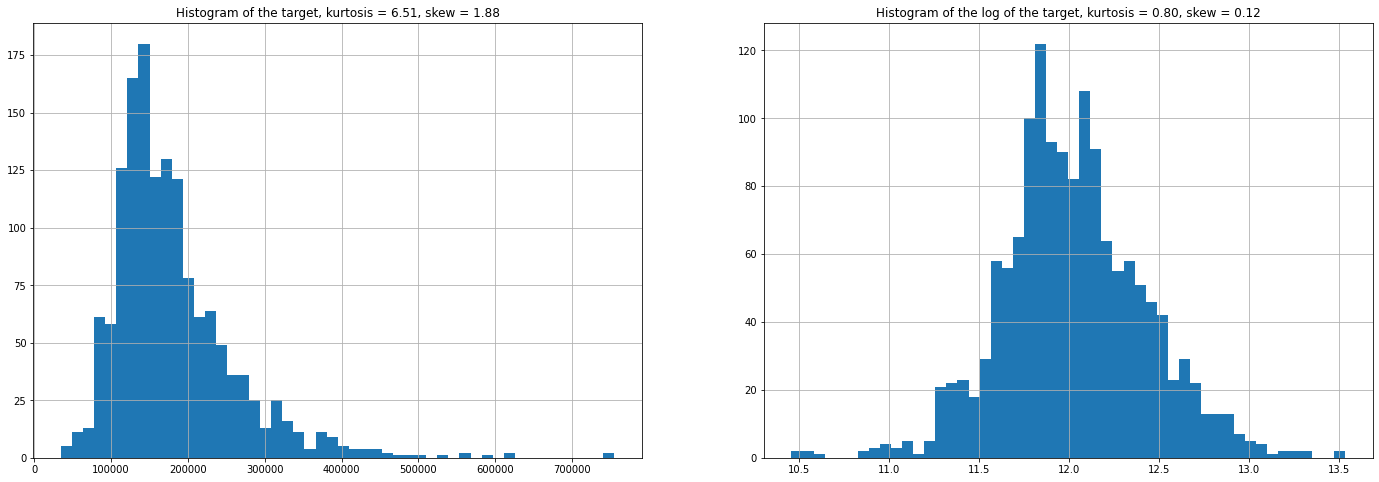

In [ ]:
X = train_df.drop(['Id','SalePrice','PricePerSqFoot','NeighAvgPPSF','DeltaPPSF','YearBuilt','YearRemodAdd','GarageYrBlt','DateSold'], axis=1)
y = train_df.SalePrice
X_submit = test_df.drop(['Id','YearBuilt','YearRemodAdd','GarageYrBlt','DateSold'], axis=1)
# concatenate train and test before one-hotting
# i do this since some categories may not appear in train or test and we would end up
# with feature matrices with different dimensions
X_agg = X.append(X_submit)
X_agg_oh = pd.get_dummies(X_agg,columns=categorical_features)
X_oh = X_agg_oh.iloc[:X.shape[0],:]
X_submit_oh = X_agg_oh.iloc[X.shape[0]:,:]

fig,axs = plt.subplots(1,2,figsize=(24,8));
y.hist(bins=50,ax=axs[0]);axs[0].set_title('Histogram of the target, kurtosis = {:.2f}, skew = {:.2f}'.format(kurtosis(y),skew(y)));
np.log(y).hist(bins=50,ax=axs[1]);axs[1].set_title('Histogram of the log of the target, kurtosis = {:.2f}, skew = {:.2f}'.format(kurtosis(np.log(y)),skew(np.log(y))));


The distribution of the target looks lognormal so I will apply a tranformation. In fact the log of the target still displays excess kurtosis but it is closer to normal and the skew is much lower. I also rescale the targets and the one hot feature matrices.


In [ ]:
y = np.log(y)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=1234)
X_train_oh, X_validation_oh, y_train, y_validation = train_test_split(X_oh, y, train_size=0.7, random_state=1234)

xStandardScaler = StandardScaler()
yStandardScaler = StandardScaler()
X_train_oh = xStandardScaler.fit_transform(X_train_oh)
X_validation_oh = xStandardScaler.transform(X_validation_oh)
X_submit_oh = xStandardScaler.transform(X_submit_oh)

y_train = yStandardScaler.fit_transform(y_train.ravel().reshape(-1, 1))
y_validation = yStandardScaler.transform(y_validation.ravel().reshape(-1, 1))

val_target = train_df.loc[X_validation.index,'SalePrice']
train_target = train_df.loc[X_train.index,'SalePrice']


# CatBoost

Now I am ready to start training. First I will use [CatBoost](https://catboost.ai/).

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9701288	test: 0.9376168	best: 0.9376168 (0)	total: 110ms	remaining: 3m 40s
1:	learn: 0.9395991	test: 0.9080253	best: 0.9080253 (1)	total: 149ms	remaining: 2m 28s
2:	learn: 0.9098520	test: 0.8817347	best: 0.8817347 (2)	total: 177ms	remaining: 1m 57s
3:	learn: 0.8822781	test: 0.8557580	best: 0.8557580 (3)	total: 205ms	remaining: 1m 42s
4:	learn: 0.8600322	test: 0.8339086	best: 0.8339086 (4)	total: 236ms	remaining: 1m 34s
5:	learn: 0.8363937	test: 0.8123405	best: 0.8123405 (5)	total: 264ms	remaining: 1m 27s
6:	learn: 0.8140848	test: 0.7896364	best: 0.7896364 (6)	total: 290ms	remaining: 1m 22s
7:	learn: 0.7922218	test: 0.7691482	best: 0.7691482 (7)	total: 319ms	remaining: 1m 19s
8:	learn: 0.7689140	test: 0.7474219	best: 0.7474219 (8)	total: 341ms	remaining: 1m 15s
9:	learn: 0.7485763	test: 0.7287710	best: 0.7287710 (9)	total: 372ms	remaining: 1m 14s
10:	learn: 0.7293265	test: 0.7109473	best: 0.7109473 (10)	total: 427ms	remaining: 1m 17s
11:	learn: 0.7098183	test: 0.6938945	best

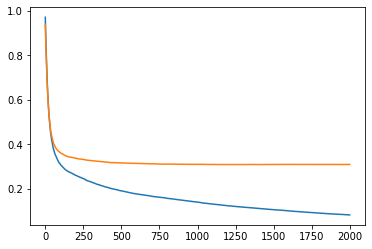

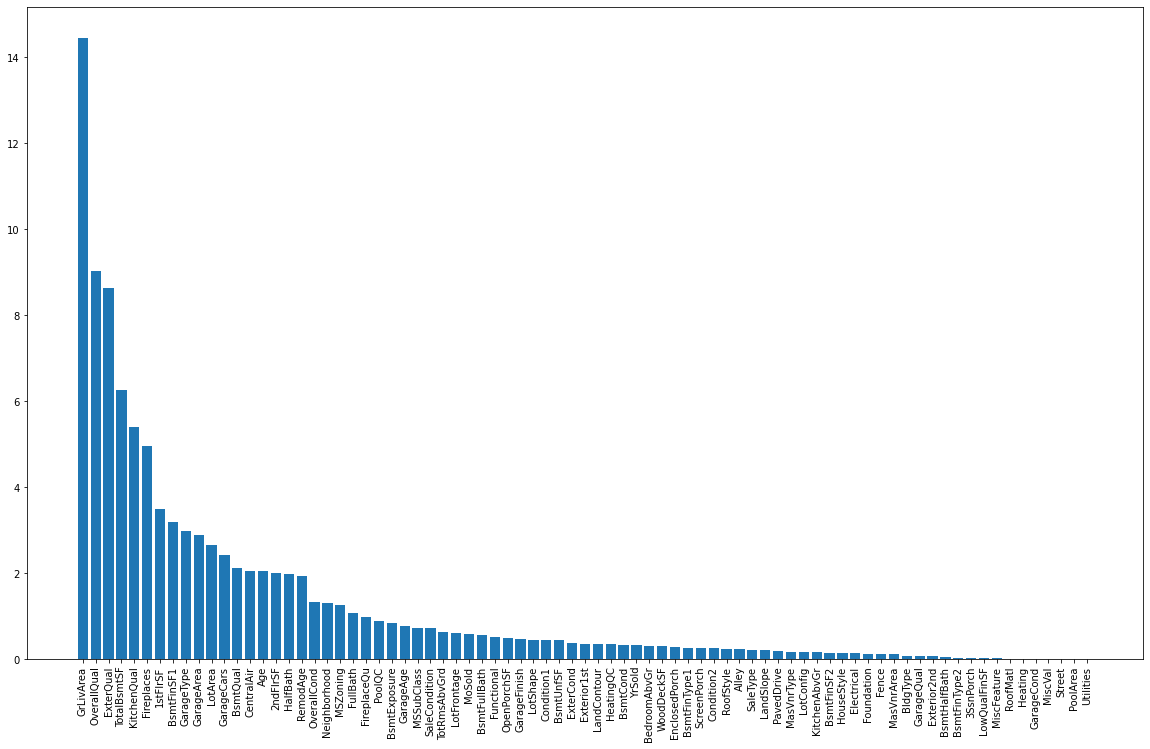

In [ ]:
#importing library and building model
categorical_features_indices = np.where(X.columns.isin(cat_boost_categorical_features))[0]
from catboost import CatBoostRegressor
model_cat_boost=CatBoostRegressor(iterations=2000, depth=5, learning_rate=0.05, loss_function='RMSE')
history = model_cat_boost.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)
plt.plot(history.evals_result_['learn']['RMSE'])
plt.plot(history.evals_result_['validation']['RMSE'])

# calculate the errors on train and val
cat_boost_predictions = np.exp(yStandardScaler.inverse_transform(model_cat_boost.predict(X_train)))
cat_boost_predictions_val = np.exp(yStandardScaler.inverse_transform(model_cat_boost.predict(X_validation)))
cat_boost_rmse = np.sqrt(np.mean((cat_boost_predictions - train_target)**2))
cat_boost_rmse_val = np.sqrt(np.mean((cat_boost_predictions_val - val_target)**2))

idx = np.argsort(model_cat_boost.get_feature_importance())[::-1]
fig,ax = plt.subplots(1,1,figsize=(20,12))
plt.bar(X_train.columns[idx],np.sort(model_cat_boost.get_feature_importance())[::-1])
plt.xticks(rotation=90);
  

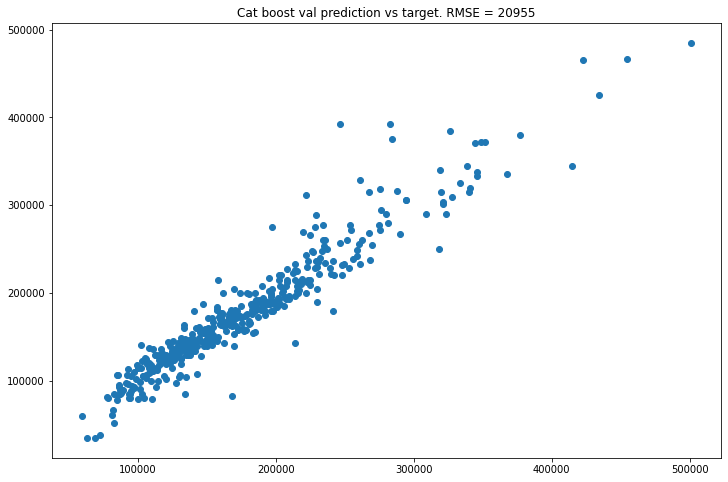

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.scatter(cat_boost_predictions_val,val_target)
plt.title('Cat boost val prediction vs target. RMSE = {:.0f}'.format(cat_boost_rmse_val));

# Lasso Regression

Next I try Lasso regression. I use [SKLearn Lasso CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html).

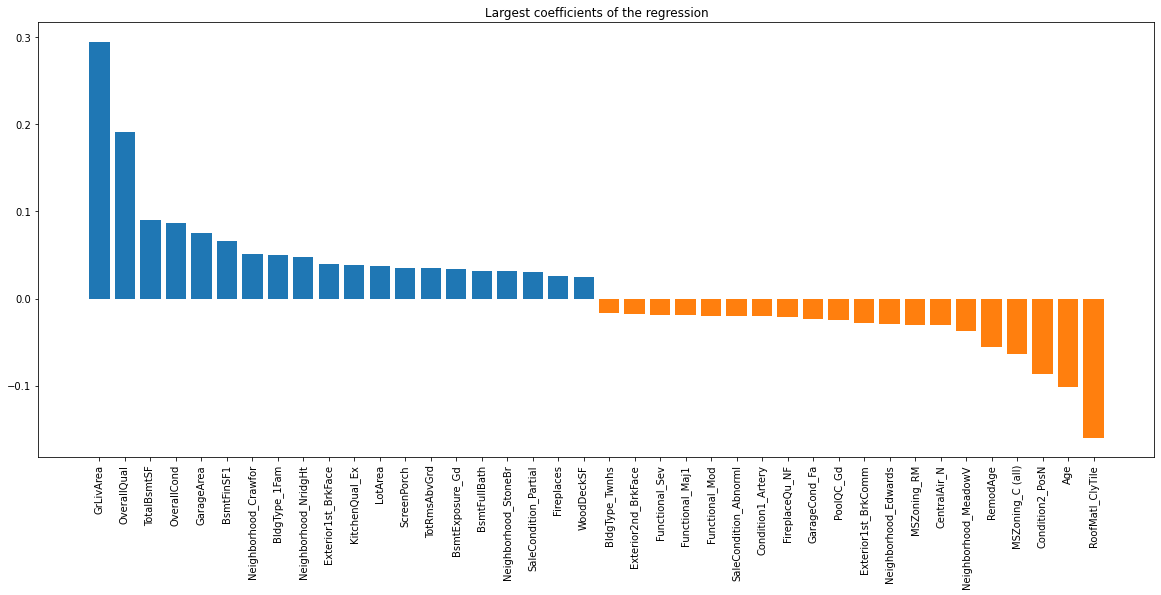

In [ ]:
alphas = np.arange(0,.1,0.005)
lasso_model = LassoCV(cv=10,alphas=alphas)
lasso_model.fit(X_train_oh,y_train.ravel())

# calculate the errors on train and val
lasso_predictions = np.exp(yStandardScaler.inverse_transform(lasso_model.predict(X_train_oh)))
lasso_rmse = np.sqrt(np.mean((lasso_predictions- train_target)**2))
lasso_predictions_val = np.exp(yStandardScaler.inverse_transform(lasso_model.predict(X_validation_oh)))
lasso_rmse_val = np.sqrt(np.mean((lasso_predictions_val- val_target)**2))

idx = np.argsort(lasso_model.coef_)[::-1]
fig,axs = plt.subplots(1,1,figsize=(20,8))
plt.bar(X_oh.columns[idx[:20]],lasso_model.coef_[idx[:20]])
plt.xticks(rotation=90);
plt.bar(X_oh.columns[idx[-20:]],lasso_model.coef_[idx[-20:]])
plt.xticks(rotation=90);
plt.title('Largest coefficients of the regression');



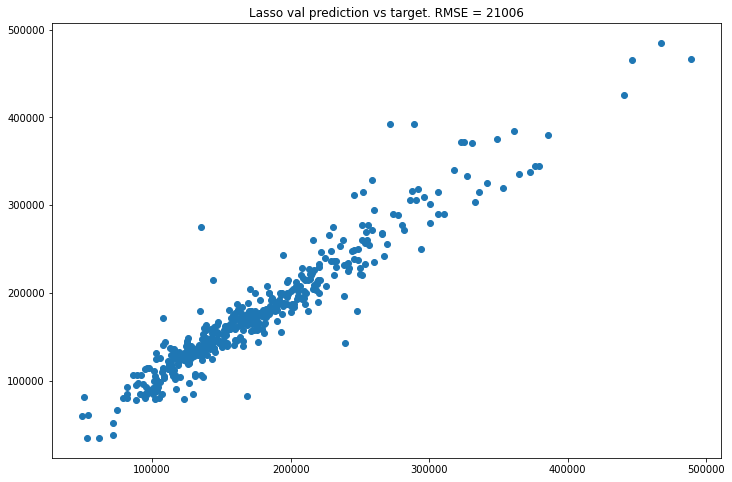

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.scatter(lasso_predictions_val,val_target)
plt.title('Lasso val prediction vs target. RMSE = {:.0f}'.format(lasso_rmse_val));

The RMSE on validation is very close to that of Cat Boost. What if we combine the predictions.

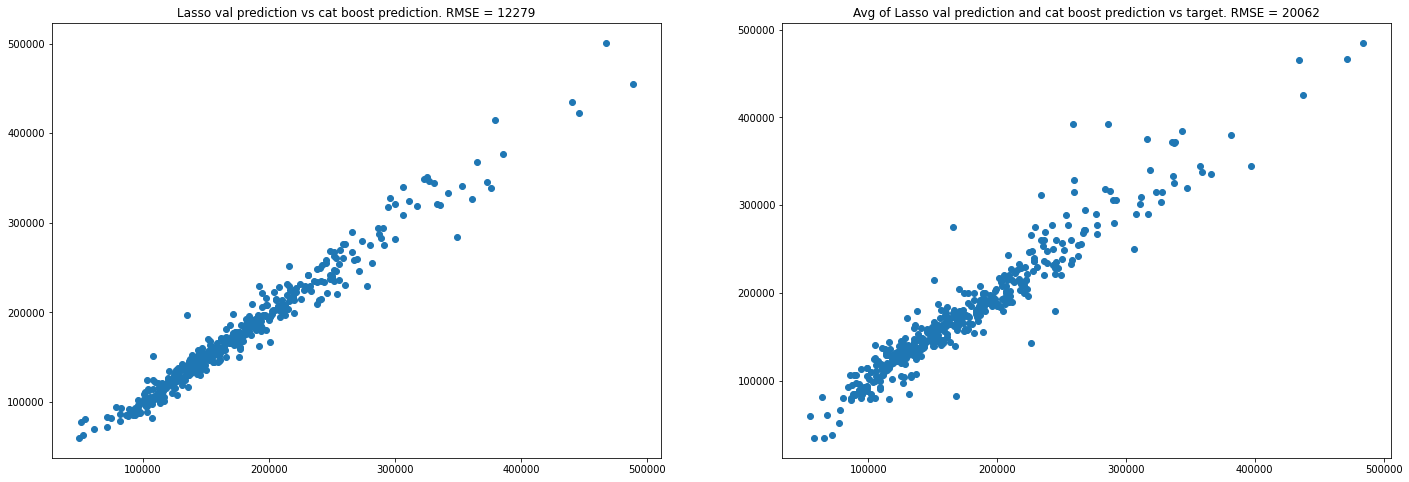

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(24,8))
rmse_cb_lasso = np.sqrt(np.mean((lasso_predictions_val-cat_boost_predictions_val)**2))
axs[0].scatter(lasso_predictions_val,cat_boost_predictions_val);
axs[0].set_title('Lasso val prediction vs cat boost prediction. RMSE = {:.0f}'.format(rmse_cb_lasso));
rmse_avg = np.sqrt(np.mean(((lasso_predictions_val+cat_boost_predictions_val)/2-val_target)**2))
axs[1].scatter((lasso_predictions_val+cat_boost_predictions_val)/2,val_target);
axs[1].set_title('Avg of Lasso val prediction and cat boost prediction vs target. RMSE = {:.0f}'.format(rmse_avg));



Even though the 2 methods produce very similar predictions, taking a simple average of the 2 predictions improves the accuracy on validation by over 4% compared to the better prediction (RMSE goes from 20,955 to 20,062). I will try a few other models to see if I can further improve on this.

#Neural Network

Epoch 1/100
16/16 [==============================] - 0s 11ms/step - loss: 0.9986 - val_loss: 0.9315
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.9828 - val_loss: 0.8832
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.8186 - val_loss: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4400 - val_loss: 0.2246
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3617 - val_loss: 0.2404
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2963 - val_loss: 0.1954
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2781 - val_loss: 0.1907
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2650 - val_loss: 0.2127
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2531 - val_loss: 0.1755
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2325 - val_loss: 0.1777
Epoch 11

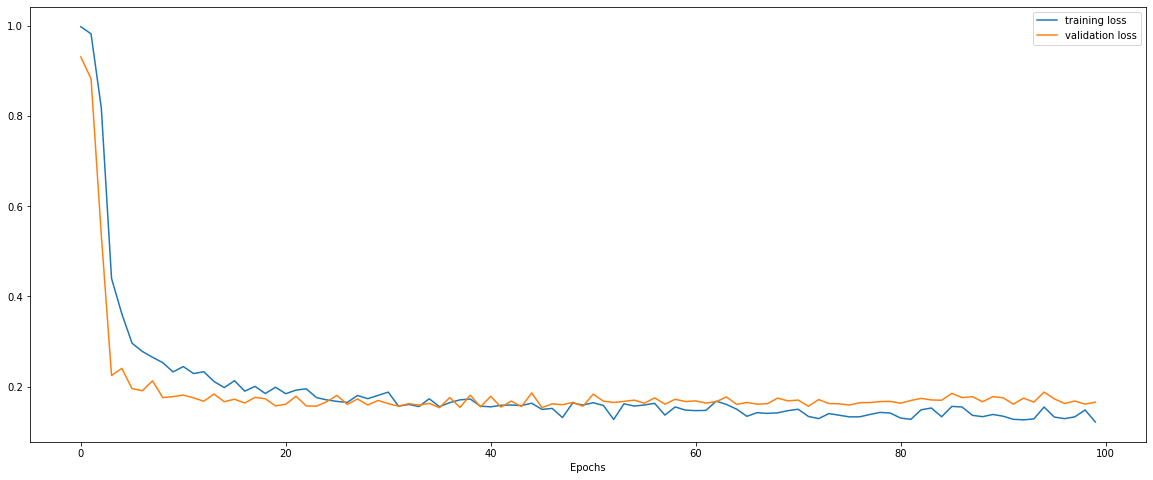

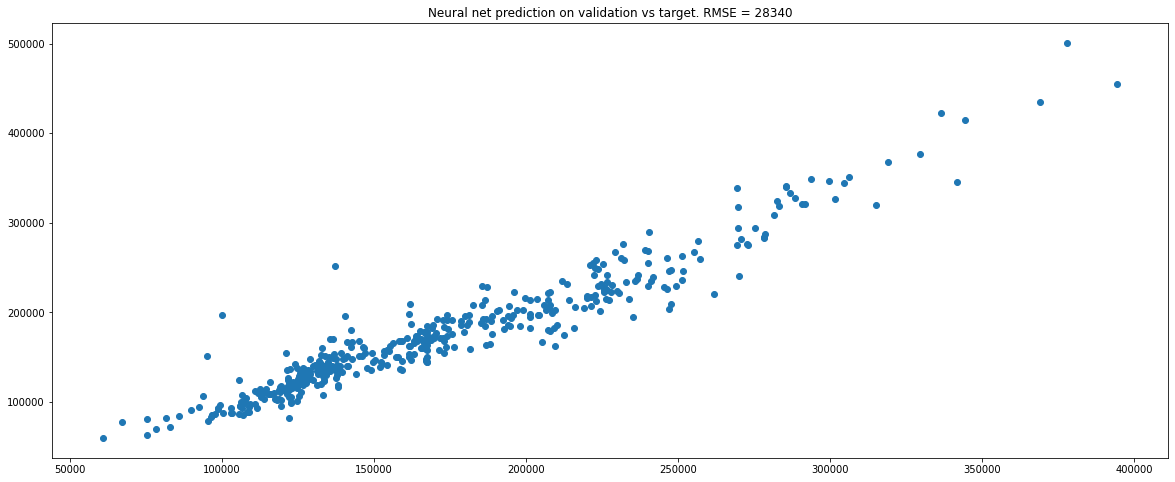

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(32, input_dim=X_train_oh.shape[1], kernel_initializer='normal', activation='relu'))
nn_model.add(Dropout(.4))
nn_model.add(Dense(32, input_dim=10, kernel_initializer='normal', activation='relu'))
nn_model.add(Dropout(.4))
nn_model.add(Dense(32, input_dim=10, kernel_initializer='normal', activation='relu'))
nn_model.add(Dropout(.4))
nn_model.add(Dense(32, input_dim=10, kernel_initializer='normal', activation='relu'))
nn_model.add(Dropout(.4))
nn_model.add(Dense(1, kernel_initializer='normal'))
# Compile model
nn_model.compile(loss='mean_squared_error', optimizer='adam')
history = nn_model.fit(X_train_oh,y_train,batch_size=64,epochs=100, validation_data=(X_validation_oh, y_validation))

nn_predictions = np.exp(yStandardScaler.inverse_transform(np.squeeze(nn_model.predict(X_train_oh))))
nn_predictions_val = np.exp(yStandardScaler.inverse_transform(np.squeeze(nn_model.predict(X_validation_oh))))
nn_rmse = np.sqrt(np.mean((np.squeeze(nn_predictions)-train_target)**2))
nn_rmse_val = np.sqrt(np.mean(((np.squeeze(nn_predictions_val)-val_target)**2)))

fig,ax = plt.subplots(1,1,figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(('training loss','validation loss'))
plt.xlabel('Epochs')


fig,axs = plt.subplots(1,1,figsize=(20,8))
plt.scatter(nn_predictions_val,cat_boost_predictions_val);
plt.title('Neural net prediction on validation vs target. RMSE = {:.0f}'.format(nn_rmse_val));


The is worse than the previous 2 models.

# Random forest regressor


In [ ]:
# random forest
rf_model = RandomForestRegressor(n_estimators = 500, criterion='mse', random_state = 42,verbose=1,max_depth=10,n_jobs=-1)
# Train the model on training data
rf_model.fit(X_train_oh, y_train)
rf_model.predict(X_validation_oh)

# calculate the errors on train and val
rf_predictions = np.exp(yStandardScaler.inverse_transform(rf_model.predict(X_train_oh)))
rf_rmse = np.sqrt(np.mean((rf_predictions- train_target)**2))
rf_predictions_val = np.exp(yStandardScaler.inverse_transform(rf_model.predict(X_validation_oh)))
rf_rmse_val = np.sqrt(np.mean((rf_predictions_val- val_target)**2))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finis

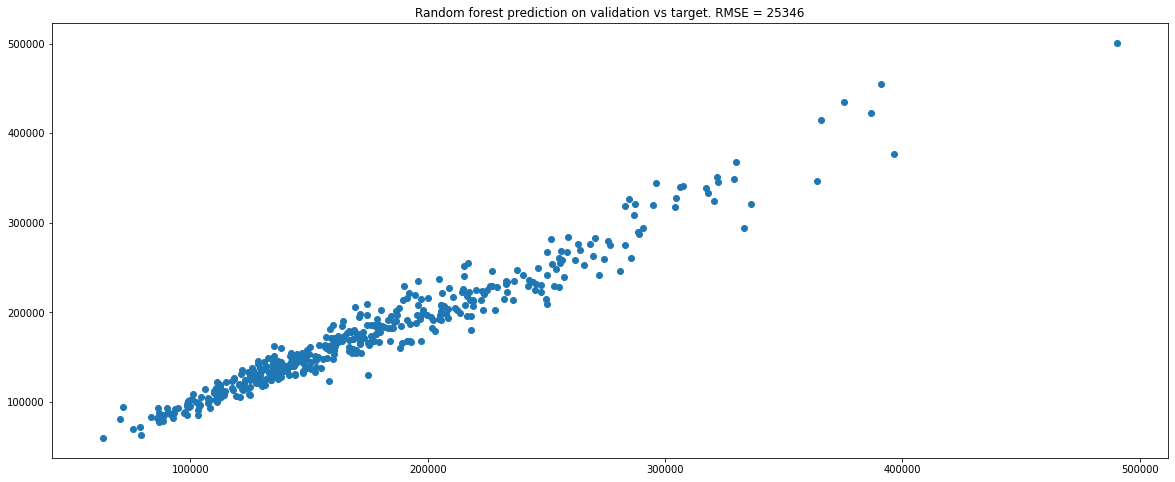

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(20,8))
plt.scatter(rf_predictions_val,cat_boost_predictions_val);
plt.title('Random forest prediction on validation vs target. RMSE = {:.0f}'.format(rf_rmse_val));


# Light GBM

[1]	training's rmse: 0.972548	valid_1's rmse: 0.941708
[2]	training's rmse: 0.945354	valid_1's rmse: 0.916623
[3]	training's rmse: 0.922647	valid_1's rmse: 0.895113
[4]	training's rmse: 0.901806	valid_1's rmse: 0.874583
[5]	training's rmse: 0.876832	valid_1's rmse: 0.850446
[6]	training's rmse: 0.852553	valid_1's rmse: 0.825743
[7]	training's rmse: 0.831776	valid_1's rmse: 0.805521
[8]	training's rmse: 0.810139	valid_1's rmse: 0.783174
[9]	training's rmse: 0.790827	valid_1's rmse: 0.76391
[10]	training's rmse: 0.772125	valid_1's rmse: 0.746963
[11]	training's rmse: 0.757069	valid_1's rmse: 0.732308
[12]	training's rmse: 0.742959	valid_1's rmse: 0.718169
[13]	training's rmse: 0.728759	valid_1's rmse: 0.703553
[14]	training's rmse: 0.713005	valid_1's rmse: 0.690335
[15]	training's rmse: 0.697763	valid_1's rmse: 0.676874
[16]	training's rmse: 0.68528	valid_1's rmse: 0.664032
[17]	training's rmse: 0.672382	valid_1's rmse: 0.652866
[18]	training's rmse: 0.660479	valid_1's rmse: 0.642172
[19

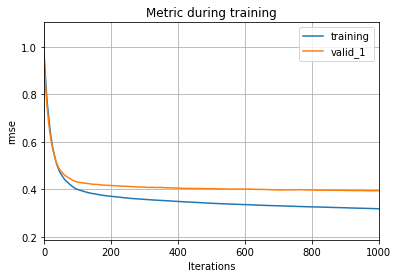

In [ ]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train_oh, np.squeeze(y_train))
lgb_val = lgb.Dataset(X_validation_oh, np.squeeze(y_validation))

lgb_params = {
              'feature_fraction': 0.5,
              'metric': 'rmse',
              'nthread':1, 
#              'max_depth':10,
              'min_data_in_leaf': 2**7, 
              'bagging_fraction': 0.5, 
              'learning_rate': 0.06,
              'objective': 'mse', 
              'bagging_seed': 2**7, 
              'num_leaves': 2**7,
              'bagging_freq':1,
              'verbose':1
            }
evals_result1 = {}
lgb_model = lgb.train(lgb_params, lgb_train, 1000,
                        valid_sets = [lgb_train,lgb_val],evals_result = evals_result1)
lgb.plot_metric(evals_result1)
lgb_pred = np.exp(yStandardScaler.inverse_transform(lgb_model.predict(X_train_oh)))
lgb_pred_val = np.exp(yStandardScaler.inverse_transform(lgb_model.predict(X_validation_oh)))
lgb_rmse = np.sqrt(np.mean((lgb_pred-train_target)**2))
lgb_rmse_val = np.sqrt(np.mean((lgb_pred_val-val_target)**2))

#Ridge regression

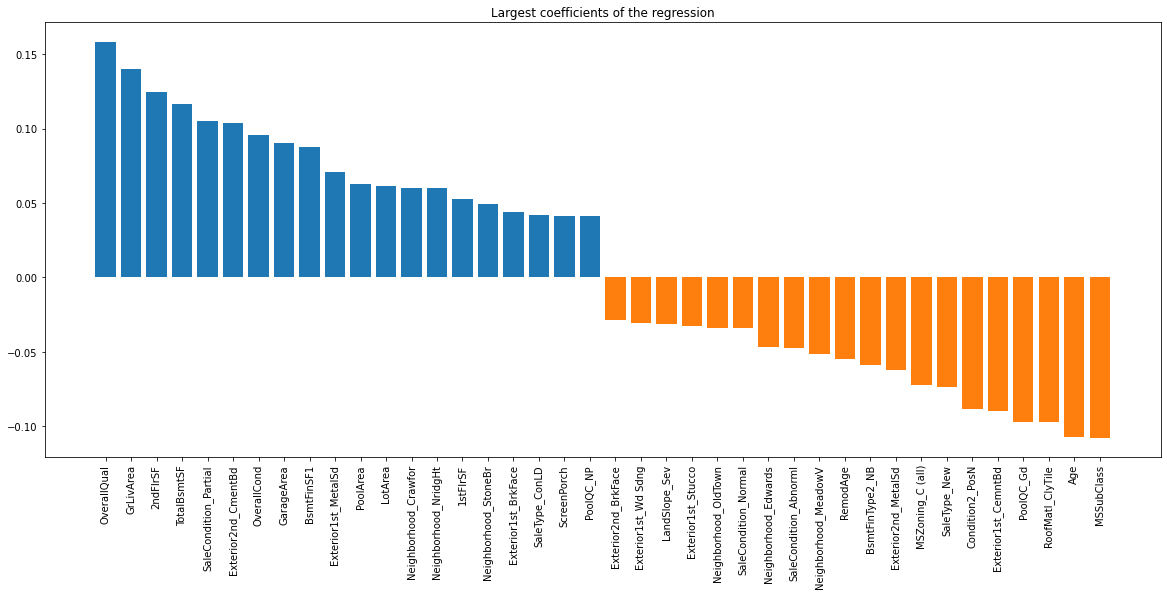

In [ ]:
alphas = np.arange(0,.5,0.005)
ridge_model = RidgeCV(cv=10,alphas=alphas)
ridge_model.fit(X_train_oh,y_train.ravel())

# calculate the errors on train and val
ridge_predictions = np.exp(yStandardScaler.inverse_transform(ridge_model.predict(X_train_oh)))
ridge_rmse = np.sqrt(np.mean((ridge_predictions- train_target)**2))
ridge_predictions_val = np.exp(yStandardScaler.inverse_transform(ridge_model.predict(X_validation_oh)))
ridge_rmse_val = np.sqrt(np.mean((ridge_predictions_val- val_target)**2))

idx = np.argsort(ridge_model.coef_)[::-1]
fig,axs = plt.subplots(1,1,figsize=(20,8))
plt.bar(X_oh.columns[idx[:20]],ridge_model.coef_[idx[:20]])
plt.xticks(rotation=90);
plt.bar(X_oh.columns[idx[-20:]],ridge_model.coef_[idx[-20:]])
plt.xticks(rotation=90);
plt.title('Largest coefficients of the regression');



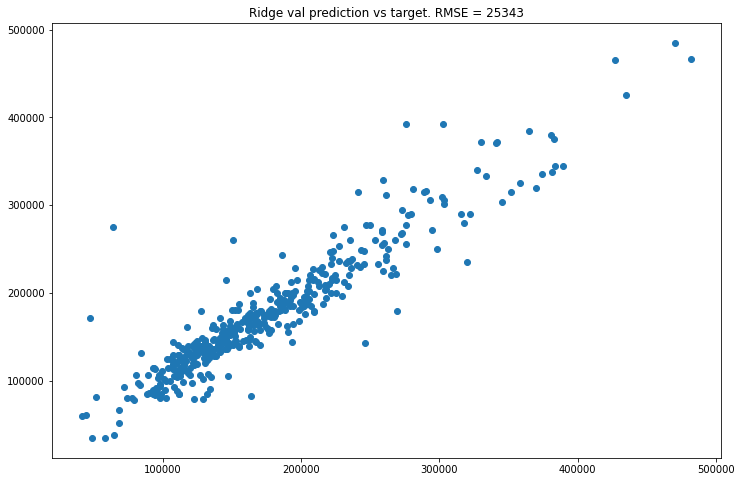

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.scatter(ridge_predictions_val,val_target)
plt.title('Ridge val prediction vs target. RMSE = {:.0f}'.format(ridge_rmse_val));

#XGBoost

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror', max_depth=3, 
    n_estimators=200,verbose_eval = True,eta =0.2, min_child_weight=5,
    subsample =0.5, col_sample_by_tree=0.5)
history = xgb_model.fit(X_train_oh, y_train,
      eval_set=[(X_train_oh, y_train), (X_validation_oh, y_validation)])
xgb_predictions = np.exp(yStandardScaler.inverse_transform(xgb_model.predict(X_train_oh)))
xgb_predictions_val = np.exp(yStandardScaler.inverse_transform(xgb_model.predict(X_validation_oh)))
xgb_rmse = np.sqrt(np.mean(((xgb_predictions-train_target)**2)))
xgb_rmse_val = np.sqrt(np.mean(((xgb_predictions_val-val_target)**2)))

[0]	validation_0-rmse:1.03459	validation_1-rmse:1.03058
[1]	validation_0-rmse:0.959767	validation_1-rmse:0.95544
[2]	validation_0-rmse:0.893309	validation_1-rmse:0.893735
[3]	validation_0-rmse:0.83318	validation_1-rmse:0.832911
[4]	validation_0-rmse:0.777751	validation_1-rmse:0.780772
[5]	validation_0-rmse:0.73214	validation_1-rmse:0.736321
[6]	validation_0-rmse:0.686489	validation_1-rmse:0.694808
[7]	validation_0-rmse:0.648829	validation_1-rmse:0.658353
[8]	validation_0-rmse:0.610063	validation_1-rmse:0.622765
[9]	validation_0-rmse:0.579909	validation_1-rmse:0.595749
[10]	validation_0-rmse:0.551406	validation_1-rmse:0.569951
[11]	validation_0-rmse:0.522621	validation_1-rmse:0.544081
[12]	validation_0-rmse:0.498381	validation_1-rmse:0.520776
[13]	validation_0-rmse:0.478324	validation_1-rmse:0.498948
[14]	validation_0-rmse:0.457637	validation_1-rmse:0.482174
[15]	validation_0-rmse:0.439197	validation_1-rmse:0.466092
[16]	validation_0-rmse:0.42387	validation_1-rmse:0.451246
[17]	validati

# Ensemble



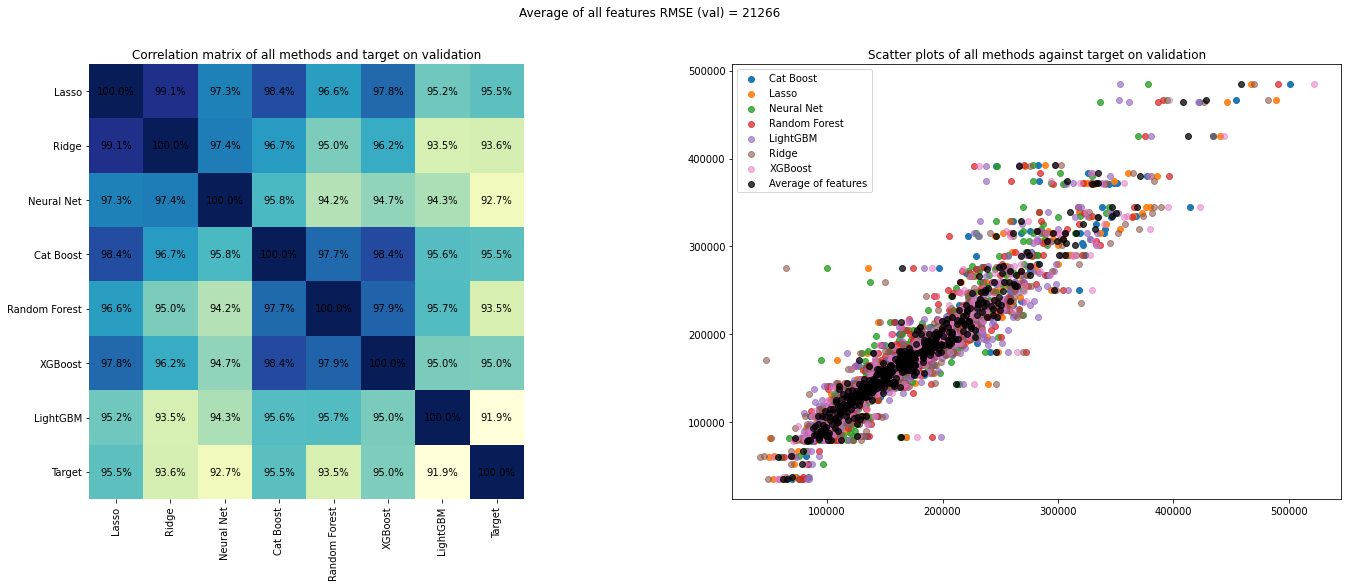

In [ ]:
val_features = np.column_stack((cat_boost_predictions_val,
                                lasso_predictions_val,
                                nn_predictions_val,
                                rf_predictions_val,
                                lgb_pred_val,
                                ridge_predictions_val,
                                xgb_predictions_val,
                                val_target))
rmse_val_avg = np.sqrt(np.mean((np.mean(val_features[:,:-1],axis=1)-val_target)**2))
rmse_val_median = np.sqrt(np.mean((np.median(val_features,axis=1)-val_target)**2))
lab = np.array(['Cat Boost','Lasso','Neural Net','Random Forest','LightGBM','Ridge','XGBoost','Target'])
mat = np.corrcoef(val_features.transpose())

pairwise_distances = sch.distance.pdist(mat)
linkage = sch.linkage(pairwise_distances, method='complete')
cluster_distance_threshold = pairwise_distances.max()/2
idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                    criterion='distance')
idx = np.argsort(idx_to_cluster_array)
mat = np.corrcoef(val_features[:,idx].transpose())
fig,ax = plt.subplots(1,2,figsize = (24,8))
fig.suptitle('Average of all features RMSE (val) = {:.0f}'.format(rmse_val_avg))
im = ax[0].imshow(mat,cmap='YlGnBu');

formater = StrMethodFormatter("{x:.1f}%");font = dict(horizontalalignment="center",verticalalignment="center")

for i in range(mat.shape[0]):
  for j in range(mat.shape[1]):
    text = im.axes.text(j, i, formater(mat[i, j]*100, None),fontdict=font)
ax[0].xaxis.set_ticks(np.arange(len(lab)));
ax[0].yaxis.set_ticks(np.arange(len(lab)));
ax[0].xaxis.set_ticklabels(lab[idx],rotation=90);
ax[0].yaxis.set_ticklabels(lab[idx]);

for edge, spine in ax[0].spines.items():
  spine.set_visible(False)
ax[0].set_title('Correlation matrix of all methods and target on validation')

for i in range(val_features.shape[1]-1):
  ax[1].scatter(val_features[:,i],val_target,alpha=.9**i)
ax[1].scatter(np.mean(val_features,axis=1),val_target,color='black',alpha=.75);

ax[1].legend(np.concatenate((lab[:-1],['Average of features'])))
ax[1].set_title('Scatter plots of all methods against target on validation');



We can see from the correlation matrix that ridge and lasso regression produce highly correlated predictions, as do the three boosting methods. Taking the average of all predictions we get a RMSE on validation of 21,404.

Text(0.5, 1.0, 'Lasso ensemble weights')

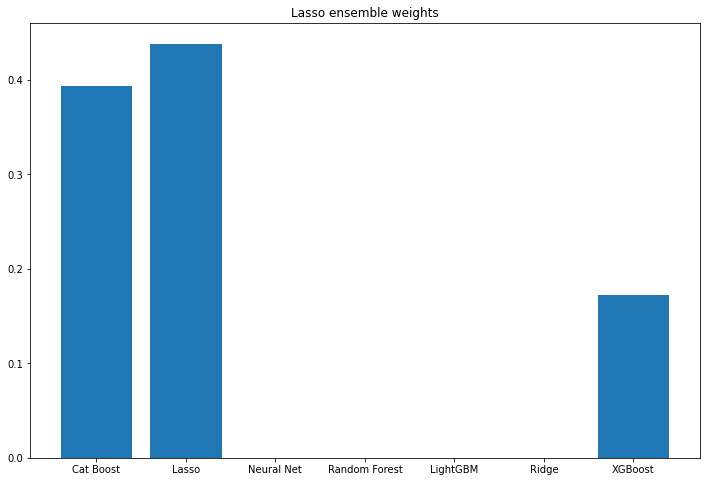

In [ ]:
lasso_ensemble = Lasso(positive=True)
lasso_ensemble.fit(val_features[:,:-1],val_features[:,-1])
lasso_ensemble.coef_
lasso_ensemble.intercept_

fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.bar(lab[:-1],lasso_ensemble.coef_);
ax.set_title('Lasso ensemble weights')

In [ ]:
# prediction for test
for feat in cat_boost_categorical_features:
  if X_submit.dtypes[feat] == np.float:
    X_submit[feat]= X_submit[feat].astype(int)

cat_boost_submit = np.exp(yStandardScaler.inverse_transform(model_cat_boost.predict(X_submit)))
lasso_submit = np.exp(yStandardScaler.inverse_transform(lasso_model.predict(X_submit_oh)))
nn_submit = np.exp(yStandardScaler.inverse_transform(np.squeeze(nn_model.predict(X_submit_oh))))
rf_submit = np.exp(yStandardScaler.inverse_transform(rf_model.predict(X_submit_oh)))
lgb_submit = np.exp(yStandardScaler.inverse_transform(lgb_model.predict(X_submit_oh)))
ridge_submit = np.exp(yStandardScaler.inverse_transform(ridge_model.predict(X_submit_oh)))
xgb_submit = np.exp(yStandardScaler.inverse_transform(xgb_model.predict(X_submit_oh)))

submit_features = np.column_stack((cat_boost_submit,
                                lasso_submit,
                                nn_submit,
                                rf_submit,
                                lgb_submit,
                                ridge_submit,
                                xgb_submit))



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


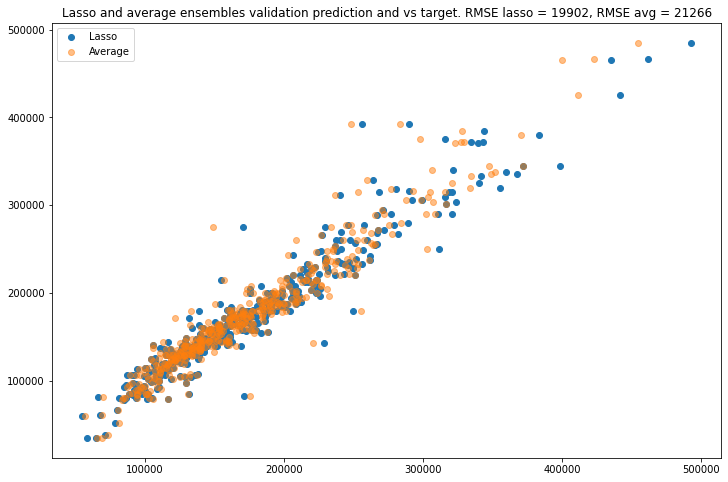

In [ ]:
lasso_ensemble_pred_submit = lasso_ensemble.predict(submit_features)
lasso_ensemble_predictions_val = lasso_ensemble.predict(val_features[:,:-1])
avg_ensemble_predictions_val = np.mean(val_features[:,:-1],axis=-1)

rmse_lasso_ensemble_val = np.sqrt(np.mean((lasso_ensemble_predictions_val-val_target)**2))
rmse_avg_ensemble_val = np.sqrt(np.mean((avg_ensemble_predictions_val-val_target)**2))
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(lasso_ensemble_predictions_val,val_target,alpha=1)
ax.scatter(avg_ensemble_predictions_val,val_target,alpha=.5)
ax.set_title('Lasso and average ensembles validation prediction and vs target. RMSE lasso = {:.0f}, RMSE avg = {:.0f}'.format(rmse_lasso_ensemble_val, rmse_avg_ensemble_val));
ax.legend(('Lasso','Average'));

# Final submission

Finally I will train the 3 best models on the full dataset using the same hpyerparameters that generalised best to validation.

In [ ]:
X = train_df.drop(['Id','SalePrice','PricePerSqFoot','NeighAvgPPSF','DeltaPPSF','YearBuilt','YearRemodAdd','GarageYrBlt','DateSold'], axis=1)
X_submit = test_df.drop(['Id','YearBuilt','YearRemodAdd','GarageYrBlt','DateSold'], axis=1)
X_submit.index = test_df.Id
y = train_df.SalePrice
y = np.log(y)

X_agg = X.append(X_submit)
X_agg_oh = pd.get_dummies(X_agg,columns=categorical_features)
X_oh = X_agg_oh.loc[X.index,:]
X_submit_oh = X_agg_oh.loc[X_submit.index,:]

xStandardScaler = StandardScaler()
yStandardScaler = StandardScaler()
X_oh = xStandardScaler.fit_transform(X_oh)
X_submit_oh = xStandardScaler.transform(X_submit_oh)
y = yStandardScaler.fit_transform(y.ravel().reshape(-1, 1))
target = train_df.loc[X.index,'SalePrice']


CatBoost final model

Streaming output truncated to the last 5000 lines.
1:	learn: 0.9407868	total: 60.7ms	remaining: 2m 31s
2:	learn: 0.9119226	total: 102ms	remaining: 2m 49s
3:	learn: 0.8856607	total: 132ms	remaining: 2m 44s
4:	learn: 0.8622070	total: 163ms	remaining: 2m 42s
5:	learn: 0.8370047	total: 191ms	remaining: 2m 38s
6:	learn: 0.8146728	total: 219ms	remaining: 2m 36s
7:	learn: 0.7913997	total: 250ms	remaining: 2m 36s
8:	learn: 0.7717919	total: 280ms	remaining: 2m 35s
9:	learn: 0.7503693	total: 305ms	remaining: 2m 32s
10:	learn: 0.7313387	total: 335ms	remaining: 2m 31s
11:	learn: 0.7130103	total: 359ms	remaining: 2m 29s
12:	learn: 0.6967050	total: 387ms	remaining: 2m 28s
13:	learn: 0.6790471	total: 411ms	remaining: 2m 26s
14:	learn: 0.6642000	total: 438ms	remaining: 2m 25s
15:	learn: 0.6479975	total: 467ms	remaining: 2m 25s
16:	learn: 0.6339352	total: 492ms	remaining: 2m 24s
17:	learn: 0.6192614	total: 516ms	remaining: 2m 22s
18:	learn: 0.6067091	total: 542ms	remaining: 2m 22s
19:	learn: 0.5929557	

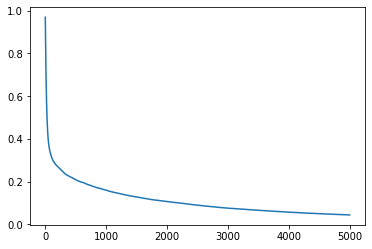

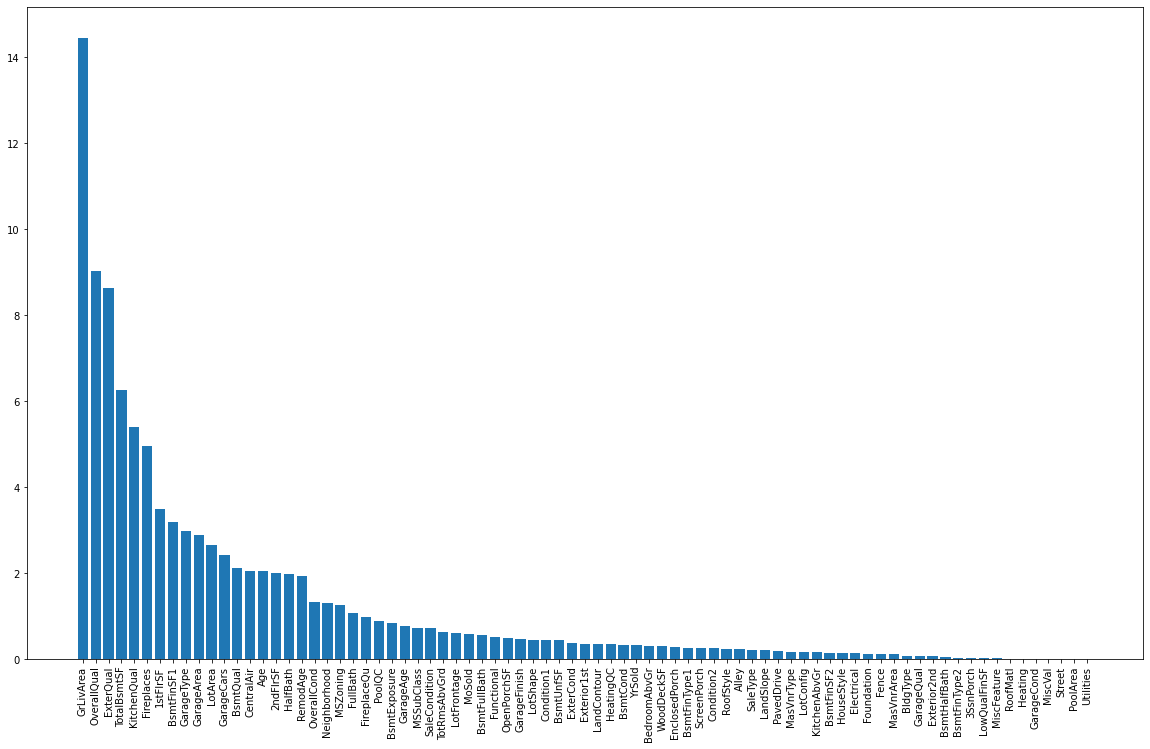

In [ ]:
model_cat_boost_final = CatBoostRegressor(iterations=5000, depth=5, learning_rate=0.05, loss_function='RMSE')
history = model_cat_boost_final.fit(X, y,cat_features=categorical_features_indices)
plt.plot(history.evals_result_['learn']['RMSE'])

# prediction for test
for feat in cat_boost_categorical_features:
  if X_submit.dtypes[feat] == np.float:
    X_submit[feat]= X_submit[feat].astype(int)

# calculate the errors on train and val
cat_boost_predictions_full = np.exp(yStandardScaler.inverse_transform(model_cat_boost_final.predict(X)))
cat_boost_rmse_full = np.sqrt(np.mean((cat_boost_predictions_full - target)**2))
cat_boost_predictions_submit_final = np.exp(
    yStandardScaler.inverse_transform(model_cat_boost_final.predict(X_submit)))


idx = np.argsort(model_cat_boost.get_feature_importance())[::-1]
fig,ax = plt.subplots(1,1,figsize=(20,12))
plt.bar(X_train.columns[idx],np.sort(model_cat_boost.get_feature_importance())[::-1])
plt.xticks(rotation=90);


Lasso regression final model

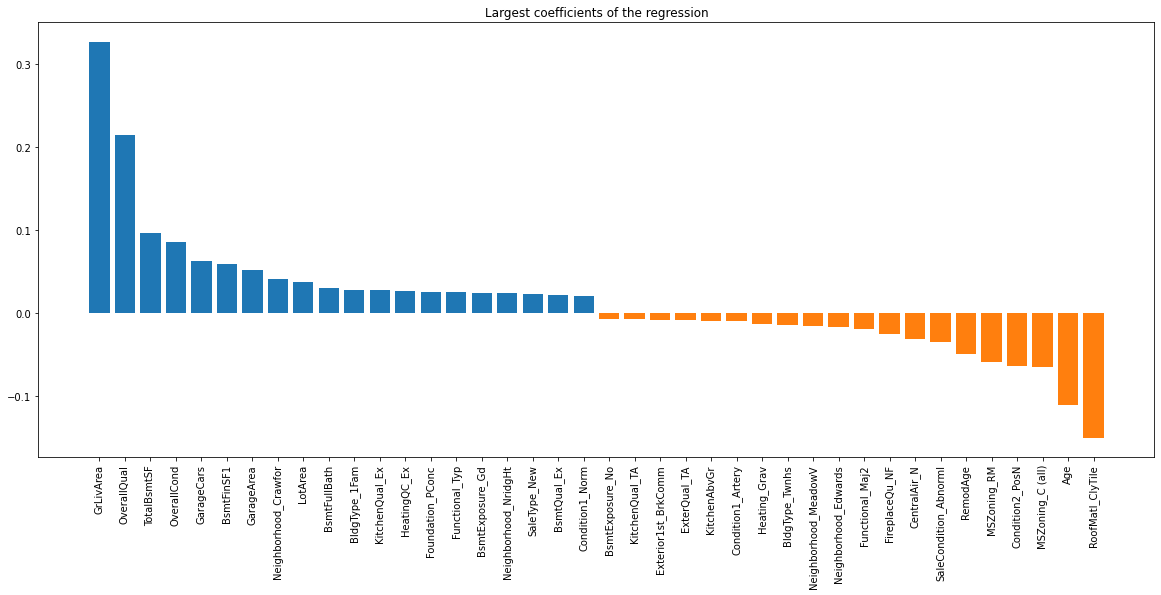

In [ ]:
alphas = np.arange(0,.1,0.005)
lasso_model_full = LassoCV(cv=10,alphas=alphas)
lasso_model_full.fit(X_oh,y.ravel())

# calculate the errors on train and val
lasso_predictions_full = np.exp(yStandardScaler.inverse_transform(lasso_model_full.predict(X_oh)))
lasso_predictions_submit_final = np.exp(
    yStandardScaler.inverse_transform(lasso_model_full.predict(X_submit_oh)))
lasso_rmse_full = np.sqrt(np.mean((lasso_predictions_full- target)**2))

idx = np.argsort(lasso_model_full.coef_)[::-1]
fig,axs = plt.subplots(1,1,figsize=(20,8))
plt.bar(X_agg_oh.columns[idx[:20]],lasso_model_full.coef_[idx[:20]])
plt.xticks(rotation=90);
plt.bar(X_agg_oh.columns[idx[-20:]],lasso_model_full.coef_[idx[-20:]])
plt.xticks(rotation=90);
plt.title('Largest coefficients of the regression');



Neural Net final model

In [ ]:
nn_model_full = Sequential()
nn_model_full.add(Dense(32, input_dim=X_train_oh.shape[1], kernel_initializer='normal', activation='relu'))
nn_model_full.add(Dropout(.4))
nn_model_full.add(Dense(32, input_dim=10, kernel_initializer='normal', activation='relu'))
nn_model_full.add(Dropout(.4))
nn_model_full.add(Dense(32, input_dim=10, kernel_initializer='normal', activation='relu'))
nn_model_full.add(Dropout(.4))
nn_model_full.add(Dense(32, input_dim=10, kernel_initializer='normal', activation='relu'))
nn_model_full.add(Dropout(.4))
nn_model_full.add(Dense(1, kernel_initializer='normal'))
# Compile model
nn_model_full.compile(loss='mean_squared_error', optimizer='adam')
history = nn_model_full.fit(X_oh,y,batch_size=64,epochs=100)

nn_predictions_full = np.squeeze(np.exp(yStandardScaler.inverse_transform(nn_model_full.predict(X_oh))))
nn_predictions_submit_final = np.exp(yStandardScaler.inverse_transform(nn_model_full.predict(X_submit_oh)))
nn_rmse = np.sqrt(np.mean(((nn_predictions_full-target)**2)))


Epoch 1/100
23/23 [==============================] - 0s 2ms/step - loss: 0.9980
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.9370
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5579
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3460
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3118
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3078
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3128
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3378
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2482
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2340
Epoch 11/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2352
Epoch 12/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2250
Epoch 13/100
23/23 [=================

XGBoost final model

In [ ]:
xgb_model_full = XGBRegressor(objective='reg:squarederror', max_depth=3, 
    n_estimators=200,verbose_eval = True,eta =0.2, min_child_weight=5,
    subsample =0.5, col_sample_by_tree=0.5)
history = xgb_model_full.fit(X_oh, y,
      eval_set=[(X_oh, y)])
xgb_predictions_full = np.exp(yStandardScaler.inverse_transform(xgb_model_full.predict(X_oh)))
xgb_predictions_submit_final = np.exp(yStandardScaler.inverse_transform(xgb_model_full.predict(X_submit_oh)))
xgb_rmse = np.sqrt(np.mean(((xgb_predictions_full-target)**2)))

[0]	validation_0-rmse:1.03225
[1]	validation_0-rmse:0.959513
[2]	validation_0-rmse:0.892629
[3]	validation_0-rmse:0.832112
[4]	validation_0-rmse:0.77976
[5]	validation_0-rmse:0.735072
[6]	validation_0-rmse:0.690151
[7]	validation_0-rmse:0.6496
[8]	validation_0-rmse:0.614924
[9]	validation_0-rmse:0.582337
[10]	validation_0-rmse:0.552601
[11]	validation_0-rmse:0.526719
[12]	validation_0-rmse:0.504659
[13]	validation_0-rmse:0.484508
[14]	validation_0-rmse:0.466757
[15]	validation_0-rmse:0.449218
[16]	validation_0-rmse:0.434986
[17]	validation_0-rmse:0.420904
[18]	validation_0-rmse:0.406594
[19]	validation_0-rmse:0.395584
[20]	validation_0-rmse:0.384835
[21]	validation_0-rmse:0.375545
[22]	validation_0-rmse:0.368257
[23]	validation_0-rmse:0.36024
[24]	validation_0-rmse:0.353319
[25]	validation_0-rmse:0.346458
[26]	validation_0-rmse:0.340154
[27]	validation_0-rmse:0.334214
[28]	validation_0-rmse:0.329437
[29]	validation_0-rmse:0.325158
[30]	validation_0-rmse:0.32158
[31]	validation_0-rmse:0

In [ ]:
final_submit = lasso_ensemble.intercept_ + lasso_ensemble.coef_[0] * cat_boost_predictions_submit_final
final_submit = final_submit + lasso_ensemble.coef_[1] * lasso_predictions_submit_final
final_submit = final_submit + lasso_ensemble.coef_[2] * nn_predictions_submit_final
final_submit = final_submit + lasso_ensemble.coef_[6] * xgb_predictions_submit_final


535152.7124588988